# Natural Language Processing

### 2.2 Scaling word2vec and introduction to Neural Nets for NLP
<br><br>
Prof. Iacopo Masi and Prof. Stefano Faralli

In [4]:
import matplotlib.pyplot as plt
import scipy
import random
import numpy as np
import pandas as pd
pd.set_option('display.colheader_justify', 'center')

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#plt.style.use('seaborn-whitegrid')

font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


# Aux functions

def plot_grid(Xs, Ys, axs=None):
    ''' Aux function to plot a grid'''
    t = np.arange(Xs.size) # define progression of int for indexing colormap
    if axs:
        axs.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        axs.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        axs.axis('scaled') # axis scaled
    else:
        plt.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        plt.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        plt.axis('scaled') # axis scaled
        
def linear_map(A, Xs, Ys):
    '''Map src points with A'''
    # [NxN,NxN] -> NxNx2 # add 3-rd axis, like adding another layer
    src = np.stack((Xs,Ys), axis=Xs.ndim)
    # flatten first two dimension
    # (NN)x2
    src_r = src.reshape(-1,src.shape[-1]) #ask reshape to keep last dimension and adjust the rest
    # 2x2 @ 2x(NN)
    dst = A @ src_r.T # 2xNN
    #(NN)x2 and then reshape as NxNx2
    dst = (dst.T).reshape(src.shape)
    # Access X and Y
    return dst[...,0], dst[...,1]


def plot_points(ax, Xs, Ys, col='red', unit=None, linestyle='solid'):
    '''Plots points'''
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='gray', linestyle="--")
    ax.axvline(x=0, color='gray',  linestyle="--")
    ax.plot(Xs, Ys, color=col)
    if unit is None:
        plotVectors(ax, [[0,1],[1,0]], ['gray']*2, alpha=1, linestyle=linestyle)
    else:
        plotVectors(ax, unit, [col]*2, alpha=1, linestyle=linestyle)

def plotVectors(ax, vecs, cols, alpha=1, linestyle='solid'):
    '''Plot set of vectors.'''
    for i in range(len(vecs)):
        x = np.concatenate([[0,0], vecs[i]])
        ax.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha, linestyle=linestyle, linewidth=2)

## My own latex definitions

$$\def\mbf#1{\mathbf{#1}}$$
$$\def\bmf#1{\boldsymbol{#1}}$$
$$\def\bx{\mbf{x}}$$
$$\def\bxt#1{\mbf{x}_{\text{#1}}}$$
$$\def\bv{\mbf{v}}$$
$$\def\bz{\mbf{z}}$$
$$\def\bmu{\bmf{\mu}}$$
$$\def\bsigma{\bmf{\Sigma}}$$
$$\def\Rd#1{\in \mathbb{R}^{#1}}$$
$$\def\chain#1#2{\frac{\partial #1}{\partial #2}}$$
$$\def\loss{\mathcal{L}}$$
$$\def\params{\bmf{\theta}}$$


# Today's lecture
## - Skip-Gram and Continuous Bag of Words (CBOW)
## - How to scale word2vec
### - Negative Sampling
### - Hierarchical Softmax
## - Introduction to Neural Nets for NLP

# This lecture material is taken from
📘 **Chapter 6 Jurafsky Book**

📘 **Chapter 14.5 Eisenstein Book**
- [Stanford Slide Word2Vec](http://web.stanford.edu/class/cs224n/slides/cs224n-2022-lecture01-wordvecs2.pdf)
- [Stanford Lecture Word2Vec](https://www.youtube.com/watch?v=rmVRLeJRkl4&list=PLoROMvodv4rOSH4v6133s9LFPRHjEmbmJ&index=1)
- [Stanford Notes on Word2Vec](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf)

Another good yet short resource is [[d2l.ai] Word embedding](https://d2l.ai/chapter_natural-language-processing-pretraining/word2vec.html)

📝 Research papers on word2vec and hierarchical softmax:
- [First paper: word2vec + hierarchical softmax](https://arxiv.org/pdf/1301.3781.pdf)
- [Negative Sampling paper](https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)
- [A Scalable Hierarchical Distributed Language Model](http://papers.nips.cc/paper/3583-a-scalable-hierarchical-distributed-language-model.pdf)

# word2vec is a generic framework 

`word2vec` presents two algorithms:
 1. ~~Skip-Gram~~
 2. **Continuous Bag-of-Word** (CBOW)  _(we see it today!)_
 

<br><br>

Also it offers different training methods:
 - ~~with naive softmax~~  
 - **negative sampling** from [Mikolov et al. 2013]
 - **hierarchical softmax** _(we see them today!)_

# word2vec: Skip-Gram Self-Supervision

⚠️ With **strong naive conditional independence assumption** 
<br/>

$$ p(w_{t-2},w_{t-1},w_{t+1},w_{t+2}|w_t;\bmf{\theta}) \approx \prod_{-m\leq j\leq m}^m p(c_{t+j}|w_t;\bmf{\theta})$$

<br/>

|   | ~~lemon~~, | ~~a~~ | [tablespoon | of | apricot | jam | a] | ~~pinch~~ |
|:-:|:------:|:-:|:-----------:|:--:|:-------:|:---:|:--:|:-----:|
|   |        |   |      w_{t-2}     | w_{t-1} |    **$w_t$**    |  w_{t+1} | w_{t+2} |       |


# word2vec: Skip-Gram Self-Supervision

Given the example below, we have to compute:
<br/>

$$p(w_{t-2}|w_t)\cdot p(w_{t-1}|w_t)\cdot p(w_{t+1}|w_t)\cdot p(w_{t+2}|w_t)$$
<br/><br/>
<div align='center'><img src="figs/word2vec_skipgram.png" width='65%' ></div>

# word2vec: Skip-Gram with softmax

Parameters to learn: $$\bmf{\theta} = [\bmf{\theta}_W;\bmf{\theta}_C]$$

<div align='center'><img src="figs/word2vec_params.png" width='45%' ></div>

# word2vec with Skip-Gram at a glance

... and why it can be seen as a tiny neural net.

<div align='center'><img src="figs/word2vec_layers.png" width='65%' ></div>

# Loss function: compare two discrete distributions
 
$$\mbf{p}=\operatorname{softmax}\big(\bmf{\theta}_C\cdot\bmf{\theta}_{W}[i]^T\big) $$

You can think $\mbf{p}$ as of this form:

|    	| lemon   	| tablespoon 	| gelato             	| ...	 | jam	|
|----------|----------	|--------	|--------------------	|--------	|--------	|
|**p (word2vec prediction)**        | 0.001 | 0.1 | 0.03  | ... | 0.15 |


Let's consider the label as a one-hot encoding vector where 1 is over the ground-truth word given by the text.

|    	| lemon   	| tablespoon 	| gelato             	| ...	 | jam	|
|----------|----------	|--------	|--------------------	|--------	|--------	|
|**y label (ground-truth $w_{t-1}$)** | 0 | 1 | 0  | ... | 0 |

### We want to adjust the weights $\bmf{\theta}$ so that $\mbf{p}$ matches the label!

# One-hot encoding is a selector!


- $\mbf{y}=[0,0,0,1,0]$ $\rightarrow$ works as a selector of probability of the actual ground-truth word that we removed!
- Of the probabilites returned by `word2vec` select that for which the index $gt$ corresponds to the `1` in the label $\mbf{y}$
- in our case, $gt$ is the index of `tablespoon` in $|V|$.

$$ \mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = -\log \big[\mbf{p}\big(w_{t-1}|w_{t}\big)\big]{[gt]}$$

# Loss function simplified

We can select immediately $[gt]$ in the numerator.

$$
\mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = -\log \left(\frac{\exp \big( \bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T \big)}{\sum_{v=1}^{V} \exp \big(\bmf{\theta}_{C}[v]\cdot\bmf{\theta}_{W}[i]^T\big)}\right)
$$

Sometimes is shown as:

$$
\mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = \underbrace{-\bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T}_{\text{similarity center vs context}} + \underbrace{\log\Big(\sum_{v=1}^{V} \exp \big(\bmf{\theta}_{C}[v]\cdot\bmf{\theta}_{W}[i]^T\big)\Big)}_{\text{make sure it is a probability}}
$$

# word2vec: Continuous Bag-of-Word (C-BOW)

# Skip-Gram

$$ p(w_{t-2},w_{t-1},w_{t+1},w_{t+2}|w_t;\bmf{\theta})$$

# C-BOW

$$ p(w_t|w_{t-2},w_{t-1},w_{t+1},w_{t+2};\bmf{\theta})$$

# word2vec: C-BOW

Given the context $w_{t-2},w_{t-1},w_{t+1},w_{t+2} \longrightarrow p(w_t)$
<br><br>


|   | ~~lemon~~, | ~~a~~ | [tablespoon | of | ----?---| jam | a] | ~~pinch~~ |
|:-:|:------:|:-:|:-----------:|:--:|:-------:|:---:|:--:|:-----:|
|   |        |   |      w_{t-2}     | w_{t-1} |    **$w_t$**    |  w_{t+1} | w_{t+2} |       |

# word2vec: Continuous Bag-of-Word (CBOW)

$$w_{t-2},w_{t-1},w_{t+1},w_{t+2} \longrightarrow p(w_t)$$<br>
 
$$\bmf{\theta}_{C_{avg}} = \sum_{-m\leq j\leq m,~j \neq 0} \bmf{\theta}_{C}[t+j]$$
<br>
<div align='center'><img src="figs/word2vec_cbow.png" width='65%' ></div>

# word2vec: Continuous Bag-of-Word (CBOW)

<div align='center'><img src="figs/word2vec_layers_cbow.png" width='65%' ></div>

# How to compute $p(w_{t-1}|w_{avg})$?
1. $\bmf{\theta}_{C_{avg}}$ is the average embedding from the context parameters $\bmf{\theta}_{C}$. The average is computed once defined the context window size.

$$\underbrace{\mbf{z}}_{|V|\times 1}=\overbrace{\underbrace{\bmf{\theta}_C}_{|V|\times D}}^{\text{as center}}\cdot\overbrace{\underbrace{\bmf{\theta}_{C_{avg}}^T}_{D\times 1}}^{\text{as context}} $$

2. $\mbf{z}$ is logits and encodes the similarity via dot product of the average context word embedding $\bmf{\theta}_{C_{avg}}$ **against all vocabulary words** taken as center $\bmf{\theta}_C$

3. We pass $\mbf{z}$ through softmax operator to get a distribution over $|V|$ as: $$\mbf{p}=\operatorname{softmax}(\mbf{z}) $$

You can think $\mbf{p}$ as of this form:

|    	| lemon   	| tablespoon 	| gelato             	| ...	 | jam	|
|----------|----------	|--------	|--------------------	|--------	|--------	|
|**p** | 0.001 | 0.1 | 0.03  | ... | 0.15 |

# Skipgram vs CBOW at a glance

<div align='center'><img src="figs/skip_vs_cbow.png" width='65%' ></div>

# Computational Complexity

- word2vec computes a **normalized probability over
word tokens (over the vocabulary $V$)**
- A naive  implementation of this probability requires <ins>summing over the entire vocabulary $V$</ins>

$$
\mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = -\log \left(\frac{\exp \big( \bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T \big)}{\sum_{v=1}^{V} \exp \big(\bmf{\theta}_{C}[v]\cdot\bmf{\theta}_{W}[i]^T\big)}\right)
$$

The normalization in the denominator is of the order of: $$ \mathcal{O}(|V|\times D)$$ where:
- $|V|$ is the vocabulary size and e.g. $|V|=3M$ 
- $D$ is the dimension of the embeddings e.g. $D=300$.

# Two solutions to approximate the denominator


1. Negative sampling (Contrastive method)
2. Hierarchical Softmax (Tree-based solution)

# Scaling word2vec with Negative Sampling

# Skip-gram with Negative Sampling (SGNS)

Instead of doing:

1. **Center word vs ground-truth context embedding** $\longrightarrow \bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T$
2. normalize as a distribution: **all context vs center word** $\longrightarrow \sum_{v=1}^{V} \exp \big(\bmf{\theta}_{C}[v]\cdot\bmf{\theta}_{W}[i]^T\big)$

$$
\mathcal{L}(w_{t-1},w_{t};\mbf{\theta}) = \underbrace{-\bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T}_{\text{similarity center vs context}} + \underbrace{\log\Big(\sum_{v=1}^{V} \exp \big(\bmf{\theta}_{C}[v]\cdot\bmf{\theta}_{W}[i]^T\big)\Big)}_{\text{make sure it is a probability}}
$$

# Skip-gram with Negative Sampling (SGNS)

We "relax" the denominator and do:

1. _[Same as before]_ **Center word vs ground-truth context embedding** $\longrightarrow \bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T$
2. Approximate the denominator as:
 - Sample a $k$ context words from $V$.
 - Compare **each $k$-th sampled word vs center word**

# Negative Sampling is a form of Contrastive Method

<br><div align='center'><img src="figs/word2vec_contrastive.png?1" width='45%' ></div>

# Negative Sampling is a form of Contrastive Method

- **Positive Constraint:**
    - Pull $\bmf{\theta}_{C}[gt]$ and $\bmf{\theta}_{W}$ to be "close" in space (give high dot-product score)
    - Center and ground-truth context need to have high similarity
    - In doing so we may make other words unrelated to be close in the space, so **we have to push them away**
- **Negative Constraint:**
    - We have to push away $\bmf{\theta}_{W}$ for any other remaining $\bmf{\theta}_{C}[i] \quad \forall i \in V, i \neq gt$ 
    - Before, this was done by forcing the total "mass" over the vocabulary distribution to sum to 1.

# Consider the simplified case: a center vs a context word

<br><div align='center'><img src="figs/word2vec_negative_onesample.png" width='65%' ></div>

# Skip-gram with Negative Sampling (SGNS)

- Given $w_t$ the center word and $w_{t-2}$ the context word to be predicted; 
- Assuming $gt$ is the index of $w_{t-2}$ in $V$ and $i$ is the index of $w_t$ in $V$: 
<br><br>
1. **[Positive] Center word vs ground-truth context embedding** $\longrightarrow \bmf{\theta}_{C}[gt]\cdot\bmf{\theta}_{W}[i]^T$
2. **[Negative]** Sample $k$ negative indexes $v$ from $V$ such that: $v \in V, v \neq gt$

### Dot Products:
$$ \underbrace{1}_{\text{positive; center vs context}} ~~~\text{vs}~~~ \underbrace{k}_{\text{negative; center vs non-context}}$$

# Skip-gram with Negative Sampling (SGNS) over a window
- Window size is $m=2$ ($m$ is one side of the window, so total context words are $2m$)
- Number of negative $k=2$

|   | ~~lemon~~, | ~~a~~ | [tablespoon | of | apricot| jam | a] | ~~pinch~~ |
|:-:|:------:|:-:|:-----------:|:--:|:-------:|:---:|:--:|:-----:|
|   |        |   |      w_{t-2}     | w_{t-1} |    **$w_t$**    |  w_{t+1} | w_{t+2} |       |

<br>
<div align='center'><img src="figs/positive.png" width='35%' ></div>

<br>
<div align='center'><img src="figs/negative.png" width='55%' ></div>

# so, how do we model that?

# From global softmax to binary classification for each pair

Recall: words are assumed all conditionally independent [it is not true in pratice!]

1. We instantiate a **binary classifier as Logistic Regression** (same as softmax but just two classes, either positive pair $y=+1$ or negative pair $y=0$)
2. We use the sigmoid function $\bmf{\sigma}$ to map the dot-product result to a probability

# Binary Logistic Regression


$$f_{\boldsymbol{\theta}}(\mbf{x}) \doteq \sigma\left(  \bmf{\theta}^T\mbf{x} \right)$$

where:

$$ \sigma(z)= \frac{1}{1+\exp^{-z}} \quad \text{sigmoid or logistic function}$$

Other important properties:

$$\sigma(z)= \frac{\exp^{z}}{1+\exp^{z}}; \quad \sigma(z)= 1-\sigma(-z) $$

<br><br> <center>Smooth and Differentiable alternative to sign</center>
<img src="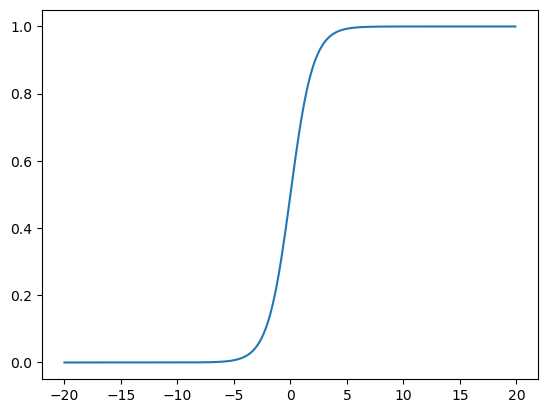
"/>

# Likelihood with negative sampling
<div align='center'><img src="figs/word2vec_negative_onesample.png" width='45%' ></div>
<br>
$$ \max_{\params} \underbrace{p(y=+1|w_{t-1},w_t;\params)}_{\text{pos. center vs context}}\cdot \underbrace{\prod_{k=1}^K p(y=0|w_k,w_t;\params)}_{\text{neg. center vs k samples}}$$

# Likelihood with negative sampling

$$ \max_{\params} \underbrace{p(y=+1|w_{t-1},w_t;\params)}_{\text{pos. center vs context}}\cdot \underbrace{\prod_{k=1}^K p(y=0|w_k,w_t;\params)}_{\text{neg. center vs k samples}}$$

We can apply $\log$ since is strictly monotonic, will not change the optimization:

$$ \max_{\params} \log p(y=+1|w_{t-1},w_t;\params)+ \log \sum_{k=1}^K p(y=0|w_k,w_t;\params)$$

$$ \max_{\params} \log p(y=+1|w_{t-1},w_t;\params)+ \log \sum_{k=1}^K \underbrace{1- p(y=+1|w_k,w_t;\params)}_{\text{it is a binary classifier!}}$$

# Likelihood with negative sampling

$$ \max_{\params} \log p(y=+1|w_{t-1},w_t;\params)+  \sum_{k=1}^K \log\big[1- p(y=+1|w_k,w_t;\params)\big]$$

We replace $p(\cdot)$ with the logistic regression and using $\sigma(-z)= 1-\sigma(z)$, we get:

$$ \max_{\params} \log \sigma \left(\params_{C}[gt]^T\params_W[i]\right)+ \sum_{k=1}^K \log \big[ \sigma\left(-\params_{C}[k]^T\params_W[i]\right)\big]$$

# Loss with negative sampling

If we minimize, we have to invert the sign:

$$ \min_{\params} -\log \sigma \left(\params_{C}[gt]^T\params_W[i]\right) - \sum_{k=1}^K \log \big[ \sigma\left(-\params_{C}[k]^T\params_W[i]\right)\big]$$

# Visualization


<div align='center'><img src="figs/negative_params.png" width='65%' ></div>

# How to sample the negatives

Which is, how to select the indexes $k \in \{1\ldots K\}, k \neq gt$ in $\sum_{k=1}^K \log \big[ \sigma\left(-\params_{C}[k]^T\params_W[i]\right)\big]$ ?

We sample from an **Unigram model** defined over the corpus $V$ as:

$$ P(v)_{\alpha} = \frac{\operatorname{count(v)^\alpha}}{\sum_{v^{\prime}}\operatorname{count(v^{\prime})^\alpha}}$$
and fixing $\alpha=\frac{3}{4}=0.75$

<br>
Setting $\alpha=0.75$ gives better performance because <b>gives rare noise words slightly
higher probability.</b> For rare words, $P(v)_{\alpha} > P(v)$ while <b>common words are more or less kept the same.</b>

# How to sample the negatives

$$ P(v)_{\alpha} = \frac{\operatorname{count(v)^\alpha}}{\sum_{v^{\prime}}\operatorname{count(v^{\prime})^\alpha}}$$
and fixing $\alpha=\frac{3}{4}=0.75$
<br><br>
**Example:**
$$\text{is:} \quad {0.9}^{.75} = 0.92\\
\text{Constitution:} \quad {0.09}^{.75} = 0.16\\
\text{bombastic:} \quad 0.01^{.75} = 0.032$$

# Sparse Gradients

- We iteratively take gradients at each window for SGD
- In each window, we only have at most $2m + 1$ words plus $2km$ negative words with negative sampling, so the gradient over a window $\nabla_{\params}\mathcal{L}_t({\params})$ is very sparse!
- Computationally, it is important to not have to send gigantic updates around.

$$
\nabla_\theta \mathcal{L}(\theta)=\left[\begin{array}{l}
\mbf{0} \\
\vdots \\
\nabla_{\params_W{_{l i k e}}} \\
\vdots \\
\mbf{0} \\
\nabla_{\params_W{_{am}}} \\
\vdots \\
\nabla_{\params_W{_{learning}}} \\
\vdots
\end{array}\right] \in \mathbb{R}^{2 d V}
$$

# Scaling word2vec with Hierarchical Softmax

# Hierarchical Softmax in NLP

It is an alternative to **Negative Sampling.** We do not use a contrastive method yet we approximate the normalization over the large vocabulary with a **balanced binary tree structure**.

Computational cost reduces from $\mathcal{O} \big( |V| \big)$ to $\mathcal{O}\big(\log_2(|V|)\big)$ **in the best case.**


# Regular Softmax is a degenerate tree!

We change point of view: softmax is a tree of depth=1 and $|V|$ children that are leaf too!

Corpus `this is an example of a huffman tree` and assume <ins>**word tokens are characters** to simplify.</ins>
<br><br>
<div align='center'><img src="figs/softmax_tree_linear.png" width='45%' ></div>


# Hierarchical Softmax in NLP

1. Given a vocabulary of word token $V$ how to construct the tree (there are multiple ways of doing it)
2. How to train with the tree
3. How to perform inference

# Huffman tree

Given a vocabulary of word token $V$ how to construct the tree? We use **Huffman trees**

The corpus is `this is an example of a huffman tree` and assume <ins>**word tokens are characters** to simplify.</ins>

| **chars** | **e** | **a** | **n** | **t** | **m** | **o** | **u** | **i** | **h** | **s** | **x** | **p** | **' '** | **f** | **r** | **l** |
|-----------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|---------|-------|-------|-------|
| **freq**  | 4     | 4     | 2     | 2     | 2     | 1     | 1     | 2     | 2     | 2     | 1     | 1     | 7       | 3     | 1     | 1     |

<div align='center'><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Huffman_tree_2.svg/938px-Huffman_tree_2.svg.png" width='35%' ></div>

<small>picture from Wikipedia</small>

# Huffman tree

- vocabulary $V \rightarrow$ word frequencies with **Unigram model.**
- More frequent word tokens are placed closer to the root; rare words are at deeper layers.
    - If you think Information Theory, we "spend" less in encoding frequent words and each word has a variable code length.
    - We want to encode `'e'` with a bit string. Convention: left is `0` and right is `1`
    -  Then encoding of `'e'` is `left->left->left` which is `000` 3 bits
    - Yet the encoding of `'p'` is `right->left->left->right->right` which is `10011` 5 bits
- Each node has always two children

# Huffman tree

| **chars** | **e** | **a** | **n** | **t** | **m** | **o** | **u** | **i** | **h** | **s** | **x** | **p** | **' '** | **f** | **r** | **l** |
|-----------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|---------|-------|-------|-------|
| **freq**  | 4     | 4     | 2     | 2     | 2     | 1     | 1     | 2     | 2     | 2     | 1     | 1     | 7       | 3     | 1     | 1     |

<br><br>
<div align='center'><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Huffman_tree_2.svg/938px-Huffman_tree_2.svg.png" width='55%' ></div>

<small>picture from Wikipedia</small>

# Training with Hierarchical Softmax

We do not model anymore $\params$ as the number of words in $V$, yet we model $\params$ as the number of internal nodes in the tree $V-1$.

We have a feature vector to be learned at each node $i$ of the tree for a total of $2V-1$ vectors to be learned (context and center).

We assume Skip-gram and we want to compute $p(w_{t-1}|w_t = \text{natural})$; we also assume the ground-truth $w_{t-1}$ is language.

<div align='center'><img src="figs/hsoftmax_1.png" width='35%' ></div>


# Training with Hierarchical Softmax

Assume Skip-gram and we want to compute $p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

So we "bypass" all paths except the one that from root leads to `language`.

<div align='center'><img src="figs/hsoftmax_2.png" width='35%' ></div>


# Training with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is "language". 

$$p(w_{t-1}|w_t = \text{natural}) = \prod_{n~\in~path(\text{root}\rightarrow \text{language})} p_{\operatorname{branch}}\big(n,i\big)$$

where: 
$$ 
p_{\operatorname{branch}}(n,i) = \begin{cases} \sigma\big(\boldsymbol{\theta}_C[n]^T\boldsymbol{\theta}_W[i])\big), & \mbox{if } \mbox{left} \\ 
1-\sigma\big(\boldsymbol{\theta}_C[n]^T\boldsymbol{\theta}_W[i])\big), & \mbox{if } \mbox{right} \end{cases} 
$$
<br>

<div align='center'><img src="figs/hsoftmax_3.png?2" width='65%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3a.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax
<br>
<div align='center'><img src="figs/hsoftmax_3b.png?2" width='75%' ></div>

# Embeddings as a Matrix

The embedding $\params_C$ are still in a matrix, where each row of the matrix is indexed by the node $n$ index.

<div align='center'><img src="figs/hsoftmax_matrix.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3b.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3c.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3d.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3e.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3f.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural})$ and we assume the ground-truth $w_{t-1}$ is language. 

<div align='center'><img src="figs/hsoftmax_3g.png?2" width='45%' ></div>

# Exercise: compute the loss with Hierarchical Softmax

$p(w_{t-1}|w_t = \text{natural}) = 1 \cdot 0.9\cdot0.95\cdot0.65\cdot0.2 = 0.11115$

Loss is $-\log\big(p(w_{t-1}|w_t = \text{natural})\big) = -\log(0.11115)$

<div align='center'><img src="figs/hsoftmax_3g.png?2" width='45%' ></div>

# Inference with Hierarchical Softmax

**Important:** In inference with do not have the label!

1. Exhaustive search [too complex]
2. Greedy search (at each branch take the branch at maximum probability) [too greedy]
3. **Beam search** (we will cover later on)



# Google Allo project used Hierarchical Softmax
Google (now dead ☠️ ) project Allo used a Hierarchical tree to speed up inference.
<br>
<div align='center'><img src="figs/allo_2016.png" width='35%' ></div>

<small>Taken from https://ai.googleblog.com/2016/05/chat-smarter-with-allo.html</small>

# Google Allo project used Hierarchical Softmax

Google (now dead ☠️ ) project Allo used a Hierarchical tree to speed up inference.
<br>
<div align='center'><img src="figs/allo_2016_beam_search.png" width='45%' ></div>

<small>Taken from https://ai.googleblog.com/2016/05/chat-smarter-with-allo.html</small>

# Google Allo project used Hierarchical Softmax

> As with any large-scale product, there were several engineering challenges we had to solve in generating a set of high-quality responses efficiently. For example, in spite of the two staged architecture, our first few networks were very slow and required about half a second to generate a response. This was obviously a deal breaker when we are talking about real time communication apps! 

> So we had to evolve our neural network architecture further to reduce the latency to less than 200ms. We moved from using **a softmax layer to a hierarchical softmax layer which traverses a tree of words instead of traversing a list of words thus making it more efficient.**

<small>Taken from https://ai.googleblog.com/2016/05/chat-smarter-with-allo.html</small>

# Hints on fastText

<div align='center'><img src=https://radimrehurek.com/gensim/_images/sphx_glr_run_fasttext_001.png width='25%' ></div>

- Morphological structure of a word carries important information about the meaning of the word.

- fastText attempts to solve this by treating each word as the aggregation of its subwords.
- Morphologically rich languages (German, Turkish) in which a single word can have a large number of morphological forms, each of which might occur rarely, thus making it hard to train good word embeddings.



# Subword Embedding

In English,
words such as
>"helps", "helped", and "helping" are 

inflected forms of the same word "help".
The relationship 
between "dog" and "dogs"
is the same as 
that between "cat" and "cats",
and 
the relationship 
between "boy" and "boyfriend"
is the same as 
that between "girl" and "girlfriend".

In other languages
such as French and Spanish,
**many verbs have over 40 inflected forms,**
while in Finnish,
a noun may have up to 15 cases.

In linguistics,
morphology studies word formation and word relationships.
However,
the internal structure of words
was neither explored in word2vec
nor in GloVe.

## The fastText Model

To use morphological information,
the *fastText* model
proposed a *subword embedding* approach,
where a **subword is a character $n$-gram**.

Instead of learning word-level vector representations,
fastText can be considered as
the **subword-level skip-gram**,
where each *center word* is represented by the sum of 
its subword vectors.

## The fastText Model

Let's illustrate how to obtain 
subwords for each center word in fastText
using the word "where".
First, add special characters “&lt;” and “&gt;” 
at the beginning and end of the word to distinguish prefixes and suffixes from other subwords. 
Then, extract character $n$-grams from the word.
For example, when $n=3$,
we obtain all subwords of length 3: "&lt;wh", "whe", "her", "ere", "re&gt;", and the special subword "&lt;where&gt;".


In fastText, for any word $w$,
denote by $\mathcal{G}_w$
the union of all its subwords of length between 3 and 6
and its special subword.
The vocabulary 
is the union of the subwords of all words.
Letting $\mathbf{z}_g$
be the vector of subword $g$ in the dictionary,
the vector $\mathbf{v}_w$ for 
word $w$ as a center word
in the skip-gram model
is the sum of its subword vectors:

$$\mathbf{v}_w = \sum_{g\in\mathcal{G}_w} \mathbf{z}_g.$$

The rest of fastText is the same as the skip-gram model. Compared with the skip-gram model, 
the vocabulary in fastText is larger,
resulting in more model parameters. 
Besides, 
to calculate the representation of a word,
all its subword vectors
have to be summed,
leading to higher computational complexity.
However,
thanks to shared parameters from subwords among words with similar structures,
rare words and even out-of-vocabulary words
may obtain better vector representations in fastText.

# Evaluating Word Embeddings

Related to general evaluation in NLP/Machine Learning: **Intrinsic vs. Extrinsic**

- **Intrinsic**:
	- Evaluation on a specific/intermediate subtask
	- Fast to compute
	- Helps to understand that system
	- Not clear if really helpful unless correlation to real task is established
    - Often involve **correlation with human judgments**


- **Extrinsic**:
	- Evaluation on a real downstream task
	- Can take a long time to compute accuracy
	- Unclear if the subsystem is the problem or its interaction or other subsystems
	- If replacing exactly one subsystem with another improves accuracy $\rightarrow$ Winner! **(Ablation study)**
	- Always perform validation of the hyper-parameter on a validation (or dev) set; when you are sure then test once.

<small>Taken from cs224n Stanford NLP with Deep learning</small>

# Embedding and Historical Semantics
<br>
<div align='center'><img src="figs/historical.png" width='65%' ></div>


# Bias and Embeddings ⚠️

In addition to their ability to learn word meaning from text, embeddings, alas, also **reproduce the implicit biases and stereotypes** that were **latent in the text**

Besides the notorious $$ \text{man} : \text{king} = \text{woman} : \text{queen}  $$

the same embeddings analogies also **exhibit gender bias**

$$ \text{man} : \text{computer programmer} = \text{woman} : \text{homemaker}  $$

$$ \text{father} : \text{doctor} = \text{mother} : \text{nurse}  $$

# Bias and Embeddings ⚠️

Bias in the embeddings can cause **allocational harm**

>when a system allocates resources (jobs or credit) unfairly to different groups. For example algorithms
that use embeddings as part of a search for hiring potential programmers or doctors
might thus incorrectly downweight documents with women's names

# Bias and Embeddings ⚠️

Bias in the embeddings can cause **representational harm** as in bias towards the ethnicity groups

> Using such methods, people
in the United States have been shown to associate African-American names with
unpleasant words (more than European-American names), male names more with
mathematics and female names with the arts, and old people’s names with unpleasant words

# Debiasing in NLP/Machine Learning is an Open-Problem

# Word Embedding: Topics we did NOT cover

- **Global Vector - GloVe** Model: taking the best of both word (SVD-based and iterative, word2vec based). Invented by Stanford.
- We only skimmed through **[fastext](https://fasttext.cc/)**: extension of word2vec to deal with the **Out of Vocabulary (OOV) problem**
    - [Fastext demo with Gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html#sphx-glr-auto-examples-tutorials-run-fasttext-py)

# Natural Language Processing with Deep Learning

# Brief recap of Neural Networks

# Today's lecture
## Supervised, <ins>Parametric</ins> Models
#### Propaedeutic part for Deep Learning

### 0) Optimization in Deep Learning
### 1) Network Structure: Multi-Layer Perceptron (MLP) is a Fully-Connected Neural Net
### 2) Backpropagation 

# This lecture material is taken from
📘 **Chapter 7 Jurafsky Book**

Another good yet short resource is [[d2l.ai] Word embedding](https://d2l.ai/chapter_natural-language-processing-pretraining/word2vec.html)

- [d2l.ai - Multi Variable Calculus](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/multivariable-calculus.html)
- [Karpathy (Tesla Machine Learning Directory) Lecture on Backprop](https://www.youtube.com/watch?v=i94OvYb6noo&t=2985s)
- [Stanford Neural Nets and Backprop lecture](https://www.youtube.com/watch?v=mpJ2bFF6o8s)
- [Stanford ML notes on Neural Nets](http://cs229.stanford.edu/summer2019/cs229-notes-deep_learning.pdf)
- [Stanford ML notes on Backprop](http://cs229.stanford.edu/notes-spring2019/backprop.pdf)
- [Animation from jermwatt.github.io  ](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_8_Momentum.html)


# Deep Learning

### 0) Quick Intro to Optimization in Deep Learning
### 1) What is a Neural Net (just Multi-Layer Perceptron)
### 2) How to obtain gradients on the weights

# Gradient Descent or Batch GD

- Compute the gradient of the loss wrt to params for **all $n$ training samples**
- $\bmf{\theta} -\gamma \sum_{i=1}^n \bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};\mbf{x}_i,y_i)$

# Stochastic Gradient Descent or SGD

- Compute the gradient of the loss wrt to params for **a single random training samples**
- $\bmf{\theta} -\gamma \bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};\mbf{x}_i,y_i)$

# How to optimize a Neural Net - SGD over mini-batches


1. In-between Batch GD and SGD with a single sample
2. We load randomly $k$ samples over the $n$; usually $k$ is a power of 2.
    - mini batch of `32, 64, 128` but could also be `100`
3. $\bmf{\theta} -\gamma \sum_{i=1}^k \bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};\mbf{x}_i,y_i)$
4. Practically you take your training set $\mathcal{X}$ and you **shuffle** it, then go over it $k$ by $k$. _Simulate uniform random sampling without replacement._
    - When the list is over, re-start and shuffle again.
5. When you have perfomed a full pass on the shuffled data, this is called an **EPOCH**
6. You can train NN over iterations or over **EPOCHS**

# Training scheme Pseudo-code

```python
from random import shuffle
training = list(range(1,11)) # each index points to a training sample, could be a matrix x=HxWx3, label y
shuffle(training)
converge, it, max_it, k, epoch = False, 0, 100, 3, 0
while not converge and it < max_it: # you training convergence scheme
    print(f'[Epoch {epoch}]')
    for b in range(0, len(training), k): # Data Loader gives you a batch k x matrices
        mini_batch = training[b:b+k] # so mini-batch is a tensor HxWx3xk
        if len(mini_batch) != k: # a possible way of handling the offset
            continue
        print('SGD step taken over', mini_batch) # compute the loss/gradients and upate your model
        loss.backward()  # get the gradients
        optimizer.step() # incorporate in the model
        # check convergence and set it to True
        it += 1
    epoch += 1 # an epoch is done, we reshuffle the training set
    shuffle(training)
```

```python
> Original unshuffled training set [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
> Training set [10, 8, 1, 2, 6, 4, 9, 7, 5, 3]
[Epoch 0]
SGD step taken over [10, 8, 1]
SGD step taken over [2, 6, 4]
SGD step taken over [9, 7, 5]
> Training set [1, 10, 6, 9, 3, 7, 8, 4, 5, 2]
[Epoch 1]
SGD step taken over [1, 10, 6]
SGD step taken over [9, 3, 7]
SGD step taken over [8, 4, 5]
> Training set [6, 3, 10, 5, 9, 8, 4, 7, 2, 1]
[Epoch 2]
SGD step taken over [6, 3, 10]
SGD step taken over [5, 9, 8]
SGD step taken over [4, 7, 2]
> Training set [1, 2, 5, 10, 6, 7, 9, 8, 3, 4]
[Epoch 3]
SGD step taken over [1, 2, 5]
SGD step taken over [10, 6, 7]
SGD step taken over [9, 8, 3]
> Training set [2, 3, 1, 9, 6, 8, 4, 10, 7, 5]
[Epoch 4]
```

# 1) SGD over mini-batches


1. **<ins>Initialization - Very Important if the function is not strictly convex</ins>** 
$$\bmf{\theta} \sim \mathcal{N}(\cdot)~~~\text{omit details for now}$$ With NN random initialization from a distribution (There are different methods). **We do not set them all to zero**
2. Repeat until **convergence**:
    - Compute the gradient of the loss wrt to the parameters $\bmf{\theta}$ given **the mini-batch**
    - Take a small step in the opposite direction of steepest ascent **(so steepest descent).**<br/><br/>
     $$\bmf{\theta} \leftarrow  \bmf{\theta} -\sum_{i=1}^k \gamma \bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};\mbf{x},y)$$
3. When convergence is reached, you final estimate is in $\bmf{\theta}$

# Change of vocabulary - A bunch of training samples is a mini-batch

- We train NN **Stochastic Gradient Descent** over mini-batches with momentum (or variations thereof)
- When you train NN you 'sample' a mini-batch $\mbf{X}_b$ from your big dataset $\mbf{X}$.


Below this holds for the final linear layer:
$$ \underbrace{\mbf{Y}}_{\mathbb{R}^{Kxn}} = \underbrace{\mbf{W}}_{\mathbb{R}^{K\times d}}\underbrace{\mbf{X}_b}_{\mathbb{R}^{d\times n}} + \underbrace{\mbf{b}}_{\mathbb{R}^K}$$

# Mini-Batch, Visually
<br>
<div align='center'><img src="figs/batch_SGD_01.png" width='75%' ></div>

# Mini-Batch SGD vs ~~[Batch]~~ GD

Loss in NN in **non-convex** with lots of local-minima so stochasticity adds noise that let the optmization escape from local minima.

<div align='center'><img src="figs/batch_SGD_02.png" width='75%' ></div>

# Mini-batch is a sort of smoothing of the single point SGD

# There is another smoothing technique: Momentum

**Top:** SGD: **Bottom:** SGD with momentum increasing memory of previous steps
<div align='center'><img src="figs/batch_SGD_03.png" width='65%' ></div>

# SGD over mini-batches with Momentum


1. **Initialization - Very Important if the function is not strictly convex** 
$$\bmf{\theta} \sim \mathcal{N}~~~\text{omit details}$$ With NN random initialization from a distribution (There are different methods). **We do not set them all to zero**
2. Repeat until **convergence**:
    - Compute the gradient of the loss wrt to the parameters $\bmf{\theta}$ given **the mini-batch**
    - Take a small step in the opposite direction of steepest ascent **(so steepest descent).**<br/><br/>
$$\bmf{\Delta}_{t+1} = \alpha\bmf{\Delta}_{t} + (1-\alpha)\underbrace{\sum_{i=1}^k\bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};\mbf{x}_i,y_i)}_{\text{new update}}$$

 $$\bmf{\theta} \leftarrow  \bmf{\theta} - \gamma \bmf{\Delta}_{t+1}$$
3. When convergence is reached (or **EARLY STOPPING**), you final estimate is in $\bmf{\theta}$

# Loss Surface for Linear Regression $\ell_2^2$ loss with $d=2$ parameters in $\bmf{\theta}$

<div align='center'><img src="figs/loss.png" width='50%' ></div>

# With Deep Learning optimization is highly non-convex and #params explode!

# Loss Surface for ResNet-20 with no skip connection on ImageNet

## ResNet-20, number of parameters $\bmf{\theta}$ of the order of.....millions!
## GPT-3 (LM behind chatpGPT) has 150 billions parameters

Visualization of mode connectivity for ResNet-20 with no skip connections on ImageNet dataset. The visualization by Javier Ideami

<center><img src=https://izmailovpavel.github.io/curves_blogpost/images/image34.jpg width='50%'/></center>

Taken from [https://izmailovpavel.github.io/curves_blogpost/](https://izmailovpavel.github.io/curves_blogpost/)

[Video for the curious student](https://www.youtube.com/watch?time_continue=5&v=dqX2LBcp5Hs&feature=emb_title)


# Learning rate is very important
<br><br>
<center><img src=https://github.com/jermwatt/machine_learning_refined/blob/gh-pages/html/gifs/steplength_1D.gif?raw=true width='85%'/></center>

# Babysitting the training process
### Loss in function of epochs

<div align='center'><img src="figs/loss_types.png" width='35%' ></div>

# Valleys, Hills, Noisy Surface
<br>
<center><img src=https://izmailovpavel.github.io/curves_blogpost/images/image1.jpg width='80%'/></center>

# Dynamics  of Training

<center><img src='http://2.bp.blogspot.com/-q6l20Vs4P_w/VPmIC7sEhnI/AAAAAAAACC4/g3UOUX2r_yA/s400/s25RsOr%2B-%2BImgur.gif' width='30%'><center/>
    
_**Noisy moons**: This is logistic regression on noisy moons dataset from sklearn which shows the smoothing effects of momentum based techniques (which also results in over shooting and correction). The error surface is visualized as an average over the whole dataset empirically, but the trajectories show the dynamics of minibatches on noisy data. The bottom chart is an accuracy plot._
    
[taken from here](http://www.denizyuret.com/2015/03/alec-radfords-animations-for.html)

# Dynamics  of Training

<center><img src='http://3.bp.blogspot.com/-nrtJPrdBWuE/VPmIB46F2aI/AAAAAAAACCw/vaE_B0SVy5k/s400/Long%2BValley%2B-%2BImgur.gif' width='30%'><center/>
   
_**Long valley**: Algos without scaling based on gradient information really struggle to break symmetry here - SGD gets no where and Nesterov Accelerated Gradient / Momentum exhibits oscillations until they build up velocity in the optimization direction. Algos that scale step size based on the gradient quickly break symmetry and begin descent._

# Just to give you an hint on where the community is headed with Deep Learning

# DALL-E OpenAI (January 2021)
<br>
<div align='center'><img src="figs/dalle.png" width='85%' ></div>

# DALL-E OpenAI 

<div align='center'><img src="figs/dalle2.png" width='85%' ></div>

# OpenAI DALL-E - 12-billion parameters trained with self-supervision

Yikes! $12\times 10^9$ floating points parameters to train

> DALL·E is a **12-billion parameter** version of GPT-3 trained to generate images from text descriptions, using a dataset of text–image pairs. We’ve found that it has a diverse set of capabilities, including creating anthropomorphized versions of animals and objects, combining unrelated concepts in plausible ways, rendering text, and applying transformations to existing images.

### ~~0) Quick Intro to Optimization in Deep Learning~~
### 1) Network Structure: Multi-Layer Perceptron (MLP) is a Fully-Connected Neural Net
### 2) Backpropagation 

# 1) Network Structure: Multi-Layer Perceptron (MLP) 
# is a Fully-Connected Neural Net

# Networks and Topics that we do NOT cover

You will meet them at **Deep Learning** course

- **Convolutional** Neural Nets (good for images or any matrix data like as input)
- Generative Adversarial Networks **(GAN)** and adversarial training
- AutoEncoders or Variational Autoencoders
- Adversarial Attacks to NN

# Networks and Topics we will cover

- Brief Recap on Feedforward NN
- Recurrent Neural Nets (RNN such as GRU, LSTM)
- Transformer Networks
- BERT, GPT-3

# Let's go back to single layer, linear soft-max regression or "linear" neural network

# Let's recall last classification layer of a neural net as pipeline
## $\mbf{x} \implies \mbf{z}= \mbf{W}\mbf{x} + \mbf{b} \implies e^{\mbf{z}}  \implies \mbf{p} = \frac{e^{\mbf{z}}}{\sum_k e^{\mbf{z}}} \implies -\ln(\mbf{p}_y) $

# word2vec with Skip-Gram at a glance

... and why it can be seen as a tiny neural net.

<div align='center'><img src="figs/word2vec_layers.png" width='65%' ></div>

# Representation of a Single Layer

Let's consider our linear softmax regressor

$$ \underbrace{\mbf{z}}_{\mathbb{R}^{Kx1}} = \underbrace{\mbf{W}}_{\mathbb{R}^{K\times d}}\underbrace{\mbf{x}}_{\mathbb{R}^{d\times1}} + \underbrace{\mbf{b}}_{\mathbb{R}^K}$$

We interpret as **Linear Layer** $\mathbf{W} \mathbf{x}+\bmf{b}$  followed by  **Non-Linear Activation function** $\sigma$

$$
\sigma(\mathbf{W} \mathbf{x}  + \bmf{b})=\sigma \circ\left(\begin{array}{cccc}
w_{11} & w_{12} & \cdots & w_{1 d} \\
w_{21} & w_{22} & \cdots & w_{2 d} \\
\vdots & \cdots & \ddots & \vdots \\
w_{k 1} & w_{m 2} & \cdots & w_{k d}
\end{array}\right)\left(\begin{array}{c}
x_{1} \\
x_{2} \\
\vdots \\
x_{d}
\end{array}\right)+
\left(\begin{array}{c}
b_{1} \\
b_{2} \\
\vdots \\
b_{k}
\end{array}\right)
=\sigma \circ\left(\begin{array}{c}
z_{1} \\
z_{2} \\
\vdots \\
z_{k}
\end{array}\right)
$$

# Representation of a Single Layer

$$
\sigma(\mathbf{W} \mathbf{x}  + \bmf{b})=\sigma \circ\left(\begin{array}{cccc}
\underline{w_{11}} & \underline{w_{12}} & \cdots & \underline{w_{1 d}} \\
w_{21} & w_{22} & \cdots & w_{2 d} \\
\vdots & \cdots & \ddots & \vdots \\
w_{k 1} & w_{m 2} & \cdots & w_{k d}
\end{array}\right)\left(\begin{array}{c}
x_{1} \\
x_{2} \\
\vdots \\
x_{d}
\end{array}\right)+
\left(\begin{array}{c}
b_{1} \\
b_{2} \\
\vdots \\
b_{k}
\end{array}\right)
=\sigma \circ\left(\begin{array}{c}
z_{1} \\
z_{2} \\
\vdots \\
z_{k}
\end{array}\right)
$$


<br><br>
<center><img src='figs/neuron.png' width='70%'/></center>

# Representation of a Single Layer

$$
\sigma(\mathbf{W} \mathbf{x}  + \bmf{b})=\sigma \circ\left(\begin{array}{cccc}
{w_{11}} & {w_{12}} & \cdots & {w_{1 d}} \\
w_{21} & w_{22} & \cdots & w_{2 d} \\
\vdots & \cdots & \ddots & \vdots \\
\underline{w_{k 1}} & \underline{w_{m 2}} & \cdots & \underline{w_{k d}}
\end{array}\right)\left(\begin{array}{c}
x_{1} \\
x_{2} \\
\vdots \\
x_{d}
\end{array}\right)+
\left(\begin{array}{c}
b_{1} \\
b_{2} \\
\vdots \\
b_{k}
\end{array}\right)
=\sigma \circ\left(\begin{array}{c}
z_{1} \\
z_{2} \\
\vdots \\
z_{k}
\end{array}\right)
$$


<br><br>
<center><img src='figs/neuron_2.png' width='70%'/></center>

# Representation of a Single Layer: Linear plus non-Linear

$$
\sigma(\mathbf{W} \mathbf{x}  + \bmf{b})=\sigma \circ\left(\begin{array}{cccc}
{w_{11}} & {w_{12}} & \cdots & {w_{1 d}} \\
w_{21} & w_{22} & \cdots & w_{2 d} \\
\vdots & \cdots & \ddots & \vdots \\
\underline{w_{k 1}} & \underline{w_{m 2}} & \cdots & \underline{w_{k d}}
\end{array}\right)\left(\begin{array}{c}
x_{1} \\
x_{2} \\
\vdots \\
x_{d}
\end{array}\right)+
\left(\begin{array}{c}
b_{1} \\
b_{2} \\
\vdots \\
b_{k}
\end{array}\right)
=\sigma \circ\left(\begin{array}{c}
z_{1} \\
z_{2} \\
\vdots \\
z_{k}
\end{array}\right)
$$


<br><br>
<center><img src='figs/neuron_3.png' width='70%'/></center>

# Representation of a Single Layer: Linear plus non-Linear

$$
\mathbf{W} \mathbf{x}=\left(\begin{array}{c}
-\text { unit - } \\
\vdots \\
-\text { unit }-
\end{array}\right)\left(\begin{array}{c}
\mid \\
\mathbf{x} \\
\mid
\end{array}\right)
$$


<br><br>
<center><img src='figs/neuron_4.png' width='70%'/></center>

# Representation as a computational graph
<br>

<div align='center'><img src="figs/graph_00.png" width='60%' ></div>

# Damn, until now is all linear. So now the "Deep"!

- Damn, until now is all linear.
- Our **beloved SoftMax+CE linear layer** is there **in the end (classifier).**

<br>
<center><img src=https://www.datasciencecentral.com/wp-content/uploads/2021/10/1-19.png width='70%'/></center>


# A single linear layer is not enough for highly  non-linear problems

<br><br>
<center><img src='https://media-exp1.licdn.com/dms/image/C5112AQEt1wEHRWi21w/article-cover_image-shrink_600_2000/0/1533914799998?e=2147483647&v=beta&t=GsPd5qJePijN7BPx2BEkNiu2OmcixkJGFA5u_XjukVg' width='50%'></center>

# Adding another non-linear layer before the classifier

- We improve the _expressivness_ of our learned function by adding another linear layer **before** the classification layer.
- Think this new layer as a feature map $\mbf{x}  \mapsto \phi(\mbf{x})$; it maps our attribute to a feature space
- Now the classifier does not classify anymore directly $\mbf{x}$ but the feature $\phi(x)$.
- Sorry, notation becomes complex. Upper script means layer index; lower-script selects the unit
- $\mathbf{W}^1 \in \mathbb{R}^{d\times p}$, $\bmf{b}^1 \in \mathbb{R}^{p}$ so then $\mathbf{W}^2 \in \mathbb{R}^{p\times k}$,   $\bmf{b}^2 \in \mathbb{R}^{k}$

$$\mbf{p}=\sigma(\mathbf{W}^2\underbrace{\left(\sigma(\mathbf{W}^1 \mathbf{x}  + \bmf{b}^1) \right)}_{\bmf{\phi}(x)}   + \bmf{b}^2)$$

$$\text{dim. analysis:} \quad d \mapsto p \mapsto k$$

# $\mathbf{W}^1 \in \mathbb{R}^{d\times p}$ is an Hidden Layer

Because it maps the original attribute in $d$ from an dimensionality $p$ and then $p$ is used for classifying.

A priori you do not know what $\mathbf{W}^1$ may learn.

$$\mbf{p}=\sigma(\mathbf{W}^2\underbrace{\left(\sigma(\mathbf{W}^1 \mathbf{x}  + \bmf{b}^1) \right)}_{\bmf{\phi}(x)}   + \bmf{b}^2)$$

$$\text{dim. analysis:} \quad d \mapsto p \mapsto k$$

# Let's update our visualizations

# Multi-Layer Perceptron (MLP) with one hidden layer

## Given the nature of these layers, they're called Fully-Connected NN

<br><br>
<center><img src='figs/neuron_5.png' width='70%'/></center>

# Multi-Layer Perceptron with one hidden layer
<br><br>
<center><img src='figs/neuron_6.png' width='90%'/></center>

# Non-linear activation functions:  Sigmoid

Very important: **Activation Functions are computed element-wise.**

$$ \sigma(z)= \frac{1}{1+\exp^{-z}} \quad \text{sigmoid or logistic function}$$

<br><br> 
<div align='center'>Smooth and Differentiable alternative to sign<img src="figs/sigmoid.png" width='35%' ></div>


# Non-linear activation functions:  Sigmoid

Very important: **Activation Functions are computed element-wise.**

$$ \sigma(z)= \frac{1}{1+\exp^{-z}} \quad \text{sigmoid or logistic function}$$
<br><br> <center>Smooth and Differentiable alternative to sign</center>

<img src="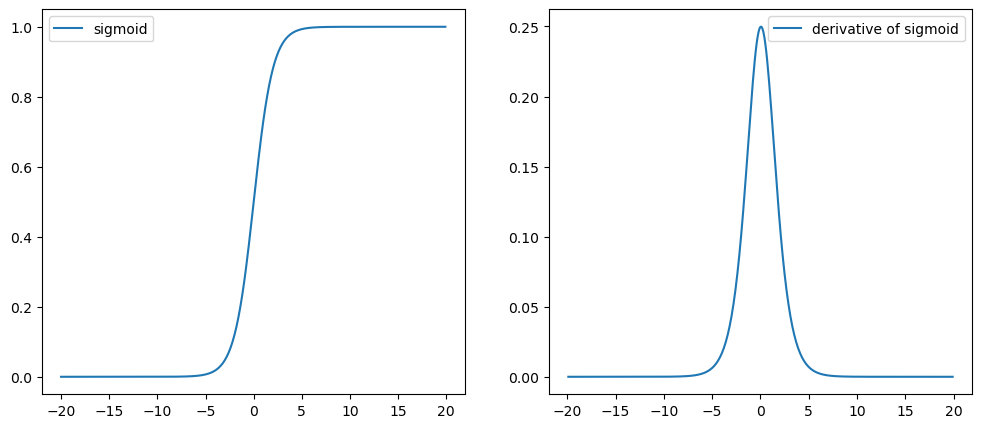
"/>


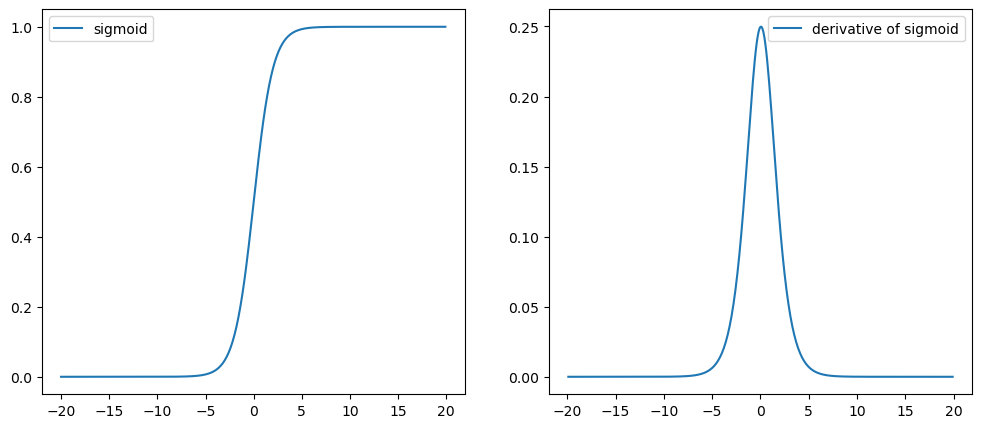

In [2]:
import numpy as np;
import matplotlib.pyplot as plt; step=0.1;
x = np.arange(-20.0, 20.0, step);
fig, axes = plt.subplots(1,2,figsize=(12,5));
y = 1/(1+np.exp(-x));
dy = np.diff(y);
axes[0].plot(x,y)
axes[0].legend(['sigmoid'])
axes[1].plot(x[1:],dy/step);
axes[1].legend(['derivative of sigmoid']);

# Non-linear activation functions:  ReLu - Rectified Linear Unit

Very important: **Activation Functions are computed element-wise.**

$$ \sigma(z)= \max(0,z) \quad \text{ReLu}$$
<br> <center>ReLu is piece-wise linear function</center>
<img src="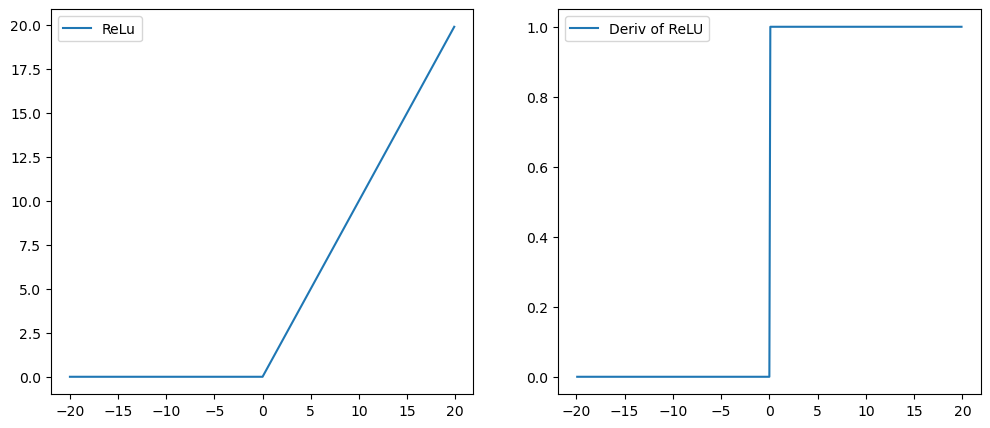
"/>

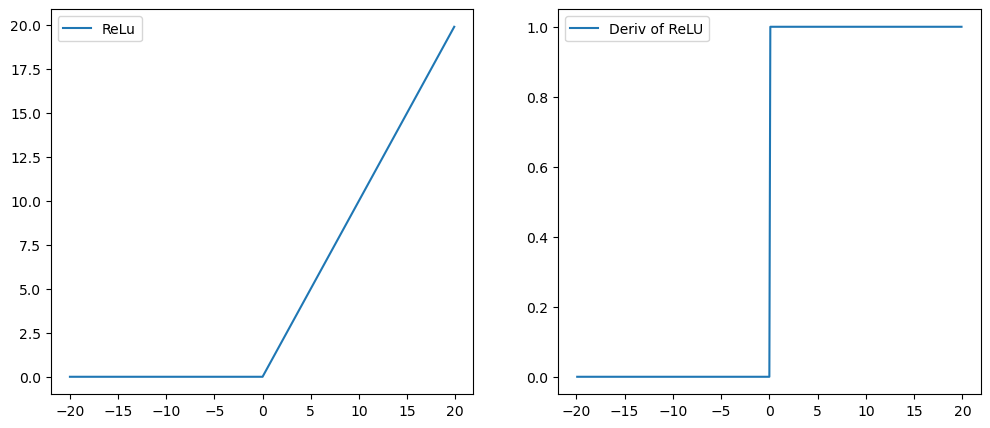

In [3]:
import numpy as np;
import matplotlib.pyplot as plt; step=0.1;
x = np.arange(-20.0, 20.0, step);
fig, axes = plt.subplots(1,2,figsize=(12,5));
y = np.maximum(0,x);
dy = np.diff(y);
axes[0].plot(x,y)
axes[1].plot(x[1:],dy/step);
axes[0].legend(['ReLu'])
_=axes[1].legend(['Deriv of ReLU']);

# Sigmoid

- Used to model output probability
- Nowdays not used in middle layers
- Have to compute $\exp()$
- **Vanishing gradients** for large input magnitude

# ReLU

- Computationally efficient (no exp!)
- No vanishing gradients but do not let pass gradients for negative values
- Converge much faster than sigmoid (6x)
- Not differentiable in zero (subgradients)

# There are other activation functions we do not cover
###  TanH, Leaky ReLU, parametrized ReLU, ELU

# Backpropagation and Differential Programming

# NN can be huge composition of functions! 😱
<br>
<center><img src=https://www.researchgate.net/profile/Tiago-Carvalho-8/publication/330478807/figure/fig1/AS:756995804110849@1557493272678/VGG16-VGG19-Inception-V3-Xception-and-ResNet-50-architectures_W640.jpg width='35%'/></center>



# Three ways of computing the gradients $\nabla_{\mbf{w}}\mathcal{L}(x,y;\mbf{w})$

1. **Manually** (if we change the network, we have to adjust it for a 100 layer neural net) maybe not a good idea, does not scale, even if we use symbolic derivation tools such as Mathematica ✍🏼
2. **Finite Difference** good to check the gradients once you have an automatic way of computing it; **very slow, unfeasible in training!** 👩🏾‍💻
3. **Backpropagation**: application of chain rule of calculus to tensors with a computational graph with caching **(differential programming with automatic differentiation)** 💻

# Backpropagation

# Let's be clear on what we need to compute

$\forall l \in [1\ldots,L]$:
1. $\nabla_{\mbf{W}^l}\mathcal{L}(\mbf{x},y;\{\mbf{W},b\})$
1. $\nabla_{\mbf{b}^l}\mathcal{L}(\mbf{x},y;\{\mbf{W},b\})$
<br><br>
<center><img src='figs/neuron_6.png' width='90%'/></center>

# Once you have gradients on ALL weights $\implies$ We can update

$\forall l \in [1\ldots,L]$:
1. $\mbf{W}^l \leftarrow \mbf{W}^l - \gamma \nabla_{\mbf{W}^l}\mathcal{L}(\mbf{x},y;\{\mbf{W},b\})$
1. $\mbf{b}^l \leftarrow \mbf{b}^l - \gamma \nabla_{\mbf{b}^l}\mathcal{L}(\mbf{x},y;\{\mbf{W},b\})$
<br><br>


<center><img src='figs/neuron_7.png' width='90%'/></center>

# How do we get all the weight updates?

[Mostly taken from here](https://www.youtube.com/watch?v=i94OvYb6noo)

# Chain Rule

Returning to functions of a single variable,
suppose that $y = f(g(x))$
and that the underlying functions 
$y=f(u)$ and $u=g(x)$ 
are both differentiable.
The chain rule states that 


$$\frac{dy}{dx} = \frac{dy}{du} \frac{du}{dx}.$$


What is the **derivative of loss wrt to x in the equation below**? $$y = loss\big(g(h(i(x)))\big)$$

$$\frac{\partial loss}{\partial x} = \frac{\partial loss}{\partial g} \frac{\partial g}{\partial h}\frac{\partial h}{\partial i}\frac{\partial i}{\partial x}$$

# Chain Rule on Directed Acyclic Graph (DAG)

### Automate the computation of derivatives with computer science



$$\mathcal{L}(x,y,z) = (x+y)z$$

$$x=-2;~y=5;~z=-4;$$

# Now with Chain Rule
$$\mathcal{L}(x,y,z) = (x+y)z$$

$$x=-2;~y=5;~z=-4;$$

but we can re-write it with the chain rule:

$$\frac{\partial\mathcal{L}(x,y,z)}{\partial x} =  \big(\underbrace{(\mbf{x}+y)}_{q}z\big)^{\prime}=\frac{\partial\mathcal{L}}{\partial q}\frac{\partial q}{\partial x}$$

# Now with Chain Rule
$$\mathcal{L}(x,y,z) = (x+y)z$$

$$x=-2;~y=5;~z=-4;$$

but we can re-write it with the chain rule:

$$\frac{\partial\mathcal{L}(x,y,z)}{\partial x} =  \big(\underbrace{(\mbf{x}+y)}_{q}z\big)^{\prime}=\frac{\partial\mathcal{L}}{\partial q}\frac{\partial q}{\partial x} = z\frac{\partial q}{\partial x} $$

# Now with Chain Rule
$$\mathcal{L}(x,y,z) = (x+y)z$$

$$x=-2;~y=5;~z=-4;$$

but we can re-write it with the chain rule:

$$\frac{\partial\mathcal{L}(x,y,z)}{\partial x} =  \big(\underbrace{(\mbf{x}+y)}_{q}z\big)^{\prime}=\frac{\partial\mathcal{L}}{\partial q}\frac{\partial q}{\partial x} = z\cdot 1= z $$

# Chain Rule on Directed Acyclic Graph (DAG)

$$\mathcal{L}(x,y,z) = (x+y)z$$

$$x=-2;~y=5;~z=-4;$$

**The computer science way:**

<div align='center'><img src="figs/dag_00.png" width='35%' ></div>

$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

# Chain Rule on Directed Acyclic Graph (DAG)
Even if the problem is very small, we break it down to subproblem so that we can **automate** it:
<div align='center'><img src="figs/dag_00.png" width='35%' ></div>


$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$
 Who is input of $\mathcal{L}$?

$q$ and $z$ are input of $\mathcal{L}$.
$$\frac{\partial\mathcal{L}}{\partial q}, \frac{\partial\mathcal{L}}{\partial z}$$

# Chain Rule on Directed Acyclic Graph (DAG)
Even if the problem is very small, we break it down to subproblem so that we can **automate** it:
<div align='center'><img src="figs/dag_00.png" width='35%' ></div>

$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

What is the derivate? (Just check the operation at the gate)
$$\frac{\partial\mathcal{L}}{\partial q}, \frac{\partial\mathcal{L}}{\partial z}$$

# Chain Rule on Directed Acyclic Graph (DAG)
Even if the problem is very small, we break it down to subproblem so that we can **automate** it:
<div align='center'><img src="figs/dag_00.png" width='35%' ></div>>


$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

What is the derivate? (Just check the operation at the gate)?
$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q$$

# Chain Rule on Directed Acyclic Graph (DAG)
Even if the problem is very small, we break it down to subproblem so that we can **automate** it:
<div align='center'><img src="figs/dag_00.png" width='35%' ></div>


$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

What is the derivate? (Just check the operation at the gate)?
$$\frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Chain Rule on Directed Acyclic Graph (DAG)
Even if the problem is very small, we break it down to subproblem so that we can **automate** it:
<div align='center'><img src="figs/dag_00.png" width='35%' ></div>


$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

OK now we have all the **analytical "local" partial derivatives, we can compute something**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Forward Pass

<div align='center'><img src="figs/dag_01.png" width='37%' ></div>


$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

OK now we have all the **analytical partial derivatives, we can compute something**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Forward Pass

<div align='center'><img src="figs/dag_02.png" width='37%' ></div>


$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

OK now we have all the **analytical partial derivatives, we can compute something**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Forward Pass

<div align='center'><img src="figs/dag_03.png" width='37%' ></div>

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_03.png" width='37%' ></div>

**Act as a base case for the recursion:** $$\frac{\partial\mathcal{L}}{\partial \mathcal{L}}=?$$

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_04.png" width='37%' ></div>

**Act as a base case for the recursion:** $$\frac{\partial\mathcal{L}}{\partial \mathcal{L}}=1$$

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_04.png" width='37%' ></div>

**What is the value of the gradient of $\mathcal{L}$ on $z$?**: 


**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_05.png" width='37%' ></div>

**What is the value of the gradient of $\mathcal{L}$ on $z$?**: 

$$\frac{\partial\mathcal{L}}{\partial z}= q = 3$$

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_05.png" width='37%' ></div>

**What is the value of the gradient of $\mathcal{L}$ on $q$?**: 


**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_06.png" width='37%' ></div>

**What is the value of the gradient of $\mathcal{L}$ on $q$?**: 

$$\frac{\partial\mathcal{L}}{\partial q}= z = -4$$

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_06.png" width='37%' ></div>

**What is the value of the gradient of $\mathcal{L}$ on $y$?**: 


**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_06.png" width='37%' ></div>

**What is the value of the gradient of $\mathcal{L}$ on $y$?**: 
$$\frac{\partial\mathcal{L}}{\partial y} = \frac{\partial\mathcal{L}}{\partial q}\frac{\partial q}{\partial y} = z\cdot 1= -4$$

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass
<div align='center'><img src="figs/dag_07.png" width='37%' ></div>

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Check with our manual derivation ✅

<div align='center'><img src="figs/dag_08.png" width='37%' ></div>

The high school way (as we did until now):

$$\frac{\partial\mathcal{L}(x,y,z)}{\partial x} =  (\mbf{x}z+yz)^{\prime}=(\mbf{x}z)^{\prime}+(yz)^{\prime} = z = -4$$
$$\frac{\partial\mathcal{L}(x,y,z)}{\partial y} =  (xz+\mbf{y}z)^{\prime}=(xz)^{\prime}+(\mbf{y}z)^{\prime} = z = -4$$
$$\frac{\partial\mathcal{L}(x,y,z)}{\partial z} =  x+y = +3 $$

# You know what? I do not trust math, I want to verify with a machine ✅

# Pytorch check
```python
from torch import tensor

def neural_net(x,y,z):
    return (x+y)*z

x, y, z = tensor(-2., requires_grad=True), tensor(5.,requires_grad=True), tensor(-4., requires_grad=True)
loss = neural_net(x,y,z) # forward pass
loss.backward()          # backward (after this I can check the gradients)
for el in [x,y,z]:
    print(el.grad)
```
```
tensor(-4.)
tensor(-4.)
tensor(3.)
```

In [22]:
from torch import tensor

def neural_net(x,y,z):
    loss = (x+y)*z
    return loss

x, y, z = tensor(-2., requires_grad=True), tensor(5.,requires_grad=True), tensor(-4., requires_grad=True)
loss = neural_net(x,y,z) # forward pass

loss.backward() #backward (ok now I can check the gradients)
for el in [x,y,z]:
    print(el.grad)

tensor(-4.)
tensor(-4.)
tensor(3.)


In [20]:
from torch import tensor

def neural_net(x,y,z):
    loss = (x+y)*z
    return loss

x, y, z = tensor(-2.)tensor(5.,requires_grad=True), tensor(-4., requires_grad=True)
loss = neural_net(x,y,z)

loss.backward()
for el in [x,y,z]:
    print(el.grad)

tensor(-4.)
tensor(-4.)
tensor(3.)


# General Recipe for Chain Rule over DAGs [Forward]

**Just remember what you have to do at a generic gate:**


<div align='center'><img src="figs/local_grad.png" width='52%' ></div>

# General Recipe for Chain Rule over DAGs  [Backward]

**Multiply the gradient that you receive with your local gradient**


<div align='center'><img src="figs/local_grad_01.png" width='52%' ></div>

# Logistic Regression Computational Graph could be simplified

$$
f(w, x)=\frac{1}{1+e^{-\left(w_{0} x_{0}+w_{1} x_{1}+b\right)}}
$$

This is what implement the **Sigmoid Layer in Pytorch:**

<div align='center'><img src="figs/dag_logistic_reg.png" width='57%' ></div>


# Are we done with training neural nets?

# Not completely: till now scalars, but we have matrices and vectors!

# Now this looks more familiar

$\forall l \in [1\ldots,L]$:
1. $\mbf{W}^l \leftarrow \mbf{W}^l - \gamma \nabla_{\mbf{W}^l}\mathcal{L}(\mbf{x},y;\{\mbf{W},b\})$
1. $\mbf{b}^l \leftarrow \mbf{b}^l - \gamma \nabla_{\mbf{b}^l}\mathcal{L}(\mbf{x},y;\{\mbf{W},b\})$
<br><br>
<div align='center'><img src="figs/graph_01.png" width='80%' ></div>

$$\chain{\mathcal{L}}{\mbf{W}^1} = \chain{\loss}{\mbf{z}}\chain{\mbf{z}}{\mbf{W}^1}$$

$$\chain{\mathcal{L}}{\mbf{W}^1} = \chain{\loss}{\mbf{z}}\underbrace{\chain{\mbf{z}}{\sigma}\chain{\mbf{\sigma}}{\mbf{W}^1}}_{\chain{\mbf{z}}{\mbf{W}^1}}$$

$$\chain{\mathcal{L}}{\mbf{W}^1} = \chain{\loss}{\mbf{z}}\chain{\mbf{z}}{\sigma}\underbrace{\chain{\mbf{\sigma}}{\mbf{h}}\chain{\mbf{h}}{\mbf{W}^1}}_{\chain{\mbf{\sigma}}{\mbf{W}^1}}$$

# Natural Language Processing with Deep Learning

# NLP Task
# Sentiment Analysis as a classification problem

# Sentiment Analysis

- We focus on one common text **categorization task: sentiment analysis**. 
- The extraction of sentiment, the positive or negative orientation that a writer expresses toward some object

> A review of a movie, book, or product on the web expresses the
author’s sentiment toward the product, while an editorial or political text expresses
sentiment toward a candidate or political action. Extracting consumer or public sentiment is thus relevant for fields from marketing to politics.

# Sentiment Analysis

<div align='center'><img src="figs/reviews.png" width='45%' ></div>

# Sentiment Analysis: what we want
<br>
<div align='center'><img src="figs/sentiment_analysis.png" width='80%' ></div>

# Sentiment Analysis: what we have
<br>
<div align='center'><img src="figs/sentiment_analysis_training.png" width='60%' ></div>

#  Feedforward Neural Net for Sentiment Analysis 
## w/ "hand-designed features"

<br>
$$
\begin{aligned}
& \mathbf{x}=\left[\mathbf{x}_1, \mathbf{x}_2, \ldots \mathbf{x}_N\right] \quad\left(\text { each } \mathbf{x}_i \text { is a hand-designed feature }\right)\\
& \mathbf{h}=\boldsymbol{\sigma}(\mathbf{W} \mathbf{x}+\mathbf{b}) \quad\left(\text{ hidden layer }\right) \\
& \mathbf{z}=\mathbf{U h} \quad\left(\text{ classification layer }\right) \\
& \hat{\mathbf{y}}=\operatorname{softmax}(\mathbf{z})
\end{aligned}
$$

<div align='center'><img src="figs/sentiment_analysis_NN_01.png" width='110%' ></div>

<div align='center'><img src="figs/sentiment_analysis_NN_01.png" width='50%' ></div>

#  Feedforward Neural Net for Sentiment Analysis 
## w/ word embeddings

We **pool** all the embeddings across the $N$ word tokens we have, using arithmetic mean **(early fusion).**

$$
\begin{aligned}
& \mathbf{x}=\text{mean}\left(\mathbf{e}_1, \mathbf{e}_2, \ldots \mathbf{e}_N\right) \quad\left(\text { each } \mathbf{e}_i \text { is a word2vec embedding}\right) \\
& \mathbf{h}=\boldsymbol{\sigma}(\mathbf{W} \mathbf{x}+\mathbf{b}) \quad\left(\text{ hidden layer }\right) \\
& \mathbf{z}=\mathbf{U h} \quad\left(\text{ classification layer }\right) \\
& \hat{\mathbf{y}}=\operatorname{softmax}(\mathbf{z})
\end{aligned}
$$


<br><br><br>
<div align='center'><img src="figs/sentiment_analysis_NN_02.png" width='120%' ></div>

# Pretraining

Learning a representation on top of another is a very important concept which is related to **pretraining** in Deep Learning. 
You can think of two alternatives:
- **Pretrain** word2vec (**offline**); then tune a 2 layer NN on top of them
- **Pretrain** word2vec (**offline**) but also tune the word2vec embeddings as you train the 2 layer NN
<div align='center'><img src="figs/sentiment_analysis_NN_02.png" width='50%' ></div>


# NLP Task
# Neural Language Model with Feedforward Neural Net

<small>Bengio et al, 2003</small>

# Neural Language Model (Pros)


Neural language models can handle:
- much longer histories, can generalize better over contexts of similar words and;
- are more accurate at word-prediction. 

# Neural Language Model (Cons)

On the other hand, neural net language models
are:
- much more complex, are slower and need more energy to train
- are less interpretable than n-gram models

# Language Model (LM)

**Language Modeling (LM)** is the task of predicting what word comes next:

> the students opened their _________

books, laptops, exams, minds?

# Language Model (LM)
More formally, given a sequence of words $w_1,\ldots,w_t$, compute the probabilities distributions over the text words $w_{t+1}$ where the support of the probability is a vocabulary $V$.

$$ p(w_{t+1}|w_t,\ldots,w_1)$$

where $w_{t+1}$ can be any word in $V = \{w_1,\ldots,_{|V|}\}$

A system that does this is called a **Language Model**

# Language Model (LM)

You can also think a LM as a **machinery that assign a probability to a piece of text of T words:**

$$ p(w_t,\ldots,w_1) = \underbrace{p(w_t,\ldots,w_2|w_1)}_{\text{recursion}} \cdot \underbrace{p(w_1)}_{\text{base case}}$$

$$ = p(w_t,\ldots,w_2|w_1) \cdot p(w_1) = p(w_t,\ldots,w_3|w_1,w_2)\cdot p(w_3|w_2,w_1) \cdot p(w_1) $$

$$= p(w_t,\ldots,w_3|w_1,w_2)\cdot p(w_3|w_2,w_1) \cdot p(w_1) = \prod_{t=2}^N p(w_{t}|w_{t-1},\ldots,w_1) \cdot p(w_1)$$

# We use LM everyday!

<div align='center'><img src="figs/swiftk_lm.png" width='50%' ></div>

# We use LM everyday!

<div align='center'><img src="figs/google_lm.png" width='50%' ></div>

# Language Model: the order matters!

> the cat is small

| 0   | 1   | 2  | 3     |
|-----|-----|----|-------|
| the | cat | is | small |

$$p(\text{the}, \text{cat}, \text{is}, \text{small}) = 0.635$$

>small the is cat

| 0     | 1   | 2   | 3  |
|-------|-----|-----|----|
| small | the | cat | is |

$$p(\text{the}, \text{cat}, \text{is}, \text{small}) = 0.0034$$

# Language Model:  N-gram

> the students opened their _________

- unigrams: "the", "students", "opened", "their"
- bigrams: "the students", "students opened", "opened their"
- trigrams: "the students opened", "students opened their"
- four-grams: "the students opened their"
\begin{equation} \label{eq1}
\begin{split}
p(\text{the}|\text{its water is so transparent that})=\\
\frac{C(\text{its water is so transparent that the})}{C(\text{its water is so transparent that}}
\end{split}
\end{equation}

# Language Model:  N-gram problems

As you increase the "window" of your context:

1. Sparsity issue increases
2. Storage problem increases

**Neural LM** took over N-gram

# A fixed-window Neural LM

- Like in N-gram, we consider only a portion of text $N$ window or context size, not the entire text.

$$ p(w_{t+1}|w_t,\ldots,w_1) \approx p(w_{t+1}|w_t,\ldots,w_{t-N})$$
- Given the context we use a Feedforward NN to predict the next word (similarly to word2vec).

> ~~As the proctor started the clock,~~ the students opened their ______________

- Unlike N-gram, it uses **distributed representations**

# A fixed-window Neural LM

<div align='center'><img src="figs/NL_01.png" width='30%' ></div>

# A fixed-window Neural LM

<div align='center'><img src="figs/NL_math_00.png" width='50%' ></div>

<br><br><div align='center'><img src="figs/NL_01.png" width='50%' ></div>

# A fixed-window Neural LM

✅ Improvements over n-gram LM 
- No sparsity problem
- No need to store all observed n-grams!

❌ Remaining problems:
- Fixed window is too small
- Enlarging window enlarges $\mbf{W}$
- Window can never be large enough!
- No symmetry in how the inputs are processed.

<br><br><div align='center'><img src="figs/NL_01.png" width='50%' ></div>

# A fixed-window Neural LM: 

<br><div align='center'><img src="figs/bengio_2003_00.png" width='50%' ></div>

# A fixed-window Neural LM: 
<br><div align='center'><img src="figs/bengio_2003_01.png" width='65%' ></div>

# Training the Neural LM: sliding window

<br><div align='center'><img src="figs/NL_03.png" width='65%' ></div>

# A fixed-window Neural LM: What we need to move forward

- An architecture that can process **any arbitrary length of context**
- **Handle word order in a better way** than concatenating embeddings.

# Appendix on Deep Learning

# Gradient Descent or Batch GD

- Compute the gradient of the loss wrt to params for **all $n$ training samples**
- $\bmf{\theta} -\gamma \sum_{i=1}^n \bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};\mbf{x}_i,y_i)$

# Stochastic Gradient Descent or SGD

- Compute the gradient of the loss wrt to params for **a single random training samples**
- $\bmf{\theta} -\gamma \bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};\mbf{x}_i,y_i)$

# How to optimize a Neural Net - SGD over mini-batches


1. In-between Batch GD and SGD with a single sample
2. We load randomly $k$ samples over the $n$; usually $k$ is a power of 2.
    - mini batch of `32, 64, 128` but could also be `100`
3. $\bmf{\theta} -\gamma \sum_{i=1}^k \bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};\mbf{x}_i,y_i)$
4. Practically you take your training set $\mathcal{X}$ and you **shuffle** it, then go over it $k$ by $k$. _Simulate uniform random sampling without replacement._
    - When the list is over, re-start and shuffle again.
5. When you have perfomed a full pass on the shuffled data, this is called an **EPOCH**
6. You can train NN over iterations or over **EPOCHS**

# Training scheme Pseudo-code

```python
from random import shuffle
training = list(range(1,11)) # each index points to a training sample, could be a matrix x=HxWx3, label y
shuffle(training)
converge, it, max_it, k, epoch = False, 0, 100, 3, 0
while not converge and it < max_it: # you training convergence scheme
    print(f'[Epoch {epoch}]')
    for b in range(0, len(training), k): # Data Loader gives you a batch k x matrices
        mini_batch = training[b:b+k] # so mini-batch is a tensor HxWx3xk
        if len(mini_batch) != k: # a possible way of handling the offset
            continue
        print('SGD step taken over', mini_batch) # compute the loss/gradients and upate your model
        loss.backward()  # get the gradients
        optimizer.step() # incorporate in the model
        # check convergence and set it to True
        it += 1
    epoch += 1 # an epoch is done, we reshuffle the training set
    shuffle(training)
```

```python
> Original unshuffled training set [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
> Training set [10, 8, 1, 2, 6, 4, 9, 7, 5, 3]
[Epoch 0]
SGD step taken over [10, 8, 1]
SGD step taken over [2, 6, 4]
SGD step taken over [9, 7, 5]
> Training set [1, 10, 6, 9, 3, 7, 8, 4, 5, 2]
[Epoch 1]
SGD step taken over [1, 10, 6]
SGD step taken over [9, 3, 7]
SGD step taken over [8, 4, 5]
> Training set [6, 3, 10, 5, 9, 8, 4, 7, 2, 1]
[Epoch 2]
SGD step taken over [6, 3, 10]
SGD step taken over [5, 9, 8]
SGD step taken over [4, 7, 2]
> Training set [1, 2, 5, 10, 6, 7, 9, 8, 3, 4]
[Epoch 3]
SGD step taken over [1, 2, 5]
SGD step taken over [10, 6, 7]
SGD step taken over [9, 8, 3]
> Training set [2, 3, 1, 9, 6, 8, 4, 10, 7, 5]
[Epoch 4]
```

# Images - Mini-batch is a tensor `HxWx3xk`
### as an example with RGB images of size $H\times W$, you have a tensor that contains $k$ images in the mini-batch

# Video Frames - Mini-batch is a tensor `HxWx3xtxk` 
### as set of frames from a video, you have a tensor that contains $k$ frames over $t$ time instants of the videos in the mini-batch


In [44]:
from random import shuffle
training = list(range(1,11))
shuffle(training)
print('> Training set', training)
converge, it, max_it, k, epoch = False, 0, 100, 3, 0
while not converge and it < max_it: # you training converge scheme
    print(f'[Epoch {epoch}]')
    for b in range(0, len(training), k): # Data Loader
        mini_batch = training[b:b+k]
        if len(mini_batch) != k:
            continue
        print('SGD step taken over', mini_batch) # compute the loss and upate your model
        it += 1
    epoch += 1 # epoch is done we reshuffle the training set
    shuffle(training)
    print('> Training set', training)

> Training set [10, 8, 1, 2, 6, 4, 9, 7, 5, 3]
[Epoch 0]
SGD step taken over [10, 8, 1]
SGD step taken over [2, 6, 4]
SGD step taken over [9, 7, 5]
> Training set [1, 10, 6, 9, 3, 7, 8, 4, 5, 2]
[Epoch 1]
SGD step taken over [1, 10, 6]
SGD step taken over [9, 3, 7]
SGD step taken over [8, 4, 5]
> Training set [6, 3, 10, 5, 9, 8, 4, 7, 2, 1]
[Epoch 2]
SGD step taken over [6, 3, 10]
SGD step taken over [5, 9, 8]
SGD step taken over [4, 7, 2]
> Training set [1, 2, 5, 10, 6, 7, 9, 8, 3, 4]
[Epoch 3]
SGD step taken over [1, 2, 5]
SGD step taken over [10, 6, 7]
SGD step taken over [9, 8, 3]
> Training set [2, 3, 1, 9, 6, 8, 4, 10, 7, 5]
[Epoch 4]
SGD step taken over [2, 3, 1]
SGD step taken over [9, 6, 8]
SGD step taken over [4, 10, 7]
> Training set [8, 5, 6, 2, 4, 7, 9, 1, 10, 3]
[Epoch 5]
SGD step taken over [8, 5, 6]
SGD step taken over [2, 4, 7]
SGD step taken over [9, 1, 10]
> Training set [8, 6, 9, 7, 5, 1, 3, 2, 10, 4]
[Epoch 6]
SGD step taken over [8, 6, 9]
SGD step taken over [7, 5

# 1) SGD over mini-batches


1. **<ins>Initialization - Very Important if the function is not strictly convex</ins>** 
$$\bmf{\theta} \sim \mathcal{N}(\cdot)~~~\text{omit details for now}$$ With NN random initialization from a distribution (There are different methods). **We do not set them all to zero**
2. Repeat until **convergence**:
    - Compute the gradient of the loss wrt to the parameters $\bmf{\theta}$ given **the mini-batch**
    - Take a small step in the opposite direction of steepest ascent **(so steepest descent).**<br/><br/>
     $$\bmf{\theta} \leftarrow  \bmf{\theta} -\sum_{i=1}^k \gamma \bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};\mbf{x},y)$$
3. When convergence is reached, you final estimate is in $\bmf{\theta}$

# Change of vocabulary - A bunch of training samples is a mini-batch

- We train NN **Stochastic Gradient Descent** over mini-batches with momentum (or variations thereof)
- When you train NN you 'sample' a mini-batch $\mbf{X}_b$ from your big dataset $\mbf{X}$.


Below this holds for the final linear layer:
$$ \underbrace{\mbf{Y}}_{\mathbb{R}^{Kxn}} = \underbrace{\mbf{W}}_{\mathbb{R}^{K\times d}}\underbrace{\mbf{X}_b}_{\mathbb{R}^{d\times n}} + \underbrace{\mbf{b}}_{\mathbb{R}^K}$$

# Mini-Batch, Visually
<br>
<div align='center'><img src="figs/batch_SGD_01.png" width='75%' ></div>

# Mini-Batch SGD vs ~~[Batch]~~ GD

Loss in NN in **non-convex** with lots of local-minima so stochasticity adds noise that let the optmization escape from local minima.

<div align='center'><img src="figs/batch_SGD_02.png" width='75%' ></div>

# Mini-batch is a sort of smoothing of the single point SGD

# There is another smoothing technique: Momentum

**Top:** SGD: **Bottom:** SGD with momentum increasing memory of previous steps
<div align='center'><img src="figs/batch_SGD_03.png" width='65%' ></div>

# SGD over mini-batches with Momentum

- We introduce an additional term **to remember what happened to the gradient in the
previous iteration.** 
- This memory dampens oscillations and smoothes out the gradient updates.
- The memory is implemented with a **exponential moving average**
- Usualy $\alpha$ (the memory param) is set to $0.9$, is a good value.


$$\bmf{\Delta}_{t} = \alpha\bmf{\Delta}_{t-1} + (1-\alpha)\underbrace{\sum_{i=1}^k\bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};\mbf{x}_i,y_i)}_{\text{new update}}$$

 $$\bmf{\theta} \leftarrow  \bmf{\theta} - \gamma \bmf{\Delta}_{t}$$

# SGD over mini-batches with Momentum


1. **Initialization - Very Important if the function is not strictly convex** 
$$\bmf{\theta} \sim \mathcal{N}~~~\text{omit details}$$ With NN random initialization from a distribution (There are different methods). **We do not set them all to zero**
2. Repeat until **convergence**:
    - Compute the gradient of the loss wrt to the parameters $\bmf{\theta}$ given **the mini-batch**
    - Take a small step in the opposite direction of steepest ascent **(so steepest descent).**<br/><br/>
$$\bmf{\Delta}_{t+1} = \alpha\bmf{\Delta}_{t} + (1-\alpha)\underbrace{\sum_{i=1}^k\bmf{\nabla}_{\bmf{\theta}}\mathcal{J}(\mbf{\theta};\mbf{x}_i,y_i)}_{\text{new update}}$$

 $$\bmf{\theta} \leftarrow  \bmf{\theta} - \gamma \bmf{\Delta}_{t+1}$$
3. When convergence is reached (or **EARLY STOPPING**), you final estimate is in $\bmf{\theta}$

# Loss Surface for Linear Regression $\ell_2^2$ loss with $d=2$ parameters in $\bmf{\theta}$

<div align='center'><img src="figs/loss.png" width='50%' ></div>

# With Deep Learning optimization is highly non-convex and #params explode!

# Loss Surface for ResNet-20 with no skip connection on ImageNet

## ResNet-20, number of parameters $\bmf{\theta}$ of the order of.....millions!
## GPT-3 (LM behind chatpGPT) has 150 billions parameters

Visualization of mode connectivity for ResNet-20 with no skip connections on ImageNet dataset. The visualization by Javier Ideami

<center><img src=https://izmailovpavel.github.io/curves_blogpost/images/image34.jpg width='50%'/></center>

Taken from [https://izmailovpavel.github.io/curves_blogpost/](https://izmailovpavel.github.io/curves_blogpost/)

[Video for the curious student](https://www.youtube.com/watch?time_continue=5&v=dqX2LBcp5Hs&feature=emb_title)


# Learning rate is very important
<br><br>
<center><img src=https://github.com/jermwatt/machine_learning_refined/blob/gh-pages/html/gifs/steplength_1D.gif?raw=true width='85%'/></center>

# Babysitting the training process
### Loss in function of epochs

<div align='center'><img src="figs/loss_types.png" width='35%' ></div>

# Valleys, Hills, Noisy Surface
<br>
<center><img src=https://izmailovpavel.github.io/curves_blogpost/images/image1.jpg width='80%'/></center>

# Dynamics  of Training

<center><img src='http://2.bp.blogspot.com/-q6l20Vs4P_w/VPmIC7sEhnI/AAAAAAAACC4/g3UOUX2r_yA/s400/s25RsOr%2B-%2BImgur.gif' width='30%'><center/>
    
_**Noisy moons**: This is logistic regression on noisy moons dataset from sklearn which shows the smoothing effects of momentum based techniques (which also results in over shooting and correction). The error surface is visualized as an average over the whole dataset empirically, but the trajectories show the dynamics of minibatches on noisy data. The bottom chart is an accuracy plot._
    
[taken from here](http://www.denizyuret.com/2015/03/alec-radfords-animations-for.html)

# Dynamics  of Training

<center><img src='http://3.bp.blogspot.com/-nrtJPrdBWuE/VPmIB46F2aI/AAAAAAAACCw/vaE_B0SVy5k/s400/Long%2BValley%2B-%2BImgur.gif' width='30%'><center/>
   
_**Long valley**: Algos without scaling based on gradient information really struggle to break symmetry here - SGD gets no where and Nesterov Accelerated Gradient / Momentum exhibits oscillations until they build up velocity in the optimization direction. Algos that scale step size based on the gradient quickly break symmetry and begin descent._

# Just to give you an hint on where the community is headed with Deep Learning

# DALL-E OpenAI (January 2021)
<br>
<div align='center'><img src="figs/dalle.png" width='85%' ></div>

# DALL-E OpenAI 

<div align='center'><img src="figs/dalle2.png" width='85%' ></div>

# OpenAI DALL-E - 12-billion parameters trained with self-supervision

Yikes! $12\times 10^9$ floating points parameters to train

> DALL·E is a **12-billion parameter** version of GPT-3 trained to generate images from text descriptions, using a dataset of text–image pairs. We’ve found that it has a diverse set of capabilities, including creating anthropomorphized versions of animals and objects, combining unrelated concepts in plausible ways, rendering text, and applying transformations to existing images.

### ~~0) Quick Intro to Optimization in Deep Learning~~
### 1) Network Structure: Multi-Layer Perceptron (MLP) is a Fully-Connected Neural Net
### 2) Backpropagation 

# 1) Network Structure: Multi-Layer Perceptron (MLP) 
# is a Fully-Connected Neural Net

# Networks and Topics that we do NOT cover

You will meet them at **Deep Learning** course

- **Convolutional** Neural Nets (good for images or any matrix data like as input)
- Generative Adversarial Networks **(GAN)** and adversarial training
- AutoEncoders or Variational Autoencoders
- Adversarial Attacks to NN

# Networks and Topics we will cover

- Brief Recap on Feedforward NN
- Recurrent Neural Nets (RNN such as GRU, LSTM)
- Transformer Networks
- BERT, GPT-3

# Let's go back to single layer, linear soft-max regression or "linear" neural network

# Let's recall last classification layer of a neural net as pipeline
## $\mbf{x} \implies \mbf{z}= \mbf{W}\mbf{x} + \mbf{b} \implies e^{\mbf{z}}  \implies \mbf{p} = \frac{e^{\mbf{z}}}{\sum_k e^{\mbf{z}}} \implies -\ln(\mbf{p}_y) $

# word2vec with Skip-Gram at a glance

... and why it can be seen as a tiny neural net.

<div align='center'><img src="figs/word2vec_layers.png" width='65%' ></div>

# Representation of a Single Layer

Let's consider our linear softmax regressor

$$ \underbrace{\mbf{z}}_{\mathbb{R}^{Kx1}} = \underbrace{\mbf{W}}_{\mathbb{R}^{K\times d}}\underbrace{\mbf{x}}_{\mathbb{R}^{d\times1}} + \underbrace{\mbf{b}}_{\mathbb{R}^K}$$

We interpret as **Linear Layer** $\mathbf{W} \mathbf{x}+\bmf{b}$  followed by  **Non-Linear Activation function** $\sigma$

$$
\sigma(\mathbf{W} \mathbf{x}  + \bmf{b})=\sigma \circ\left(\begin{array}{cccc}
w_{11} & w_{12} & \cdots & w_{1 d} \\
w_{21} & w_{22} & \cdots & w_{2 d} \\
\vdots & \cdots & \ddots & \vdots \\
w_{k 1} & w_{m 2} & \cdots & w_{k d}
\end{array}\right)\left(\begin{array}{c}
x_{1} \\
x_{2} \\
\vdots \\
x_{d}
\end{array}\right)+
\left(\begin{array}{c}
b_{1} \\
b_{2} \\
\vdots \\
b_{k}
\end{array}\right)
=\sigma \circ\left(\begin{array}{c}
z_{1} \\
z_{2} \\
\vdots \\
z_{k}
\end{array}\right)
$$

# Representation of a Single Layer

$$
\sigma(\mathbf{W} \mathbf{x}  + \bmf{b})=\sigma \circ\left(\begin{array}{cccc}
\underline{w_{11}} & \underline{w_{12}} & \cdots & \underline{w_{1 d}} \\
w_{21} & w_{22} & \cdots & w_{2 d} \\
\vdots & \cdots & \ddots & \vdots \\
w_{k 1} & w_{m 2} & \cdots & w_{k d}
\end{array}\right)\left(\begin{array}{c}
x_{1} \\
x_{2} \\
\vdots \\
x_{d}
\end{array}\right)+
\left(\begin{array}{c}
b_{1} \\
b_{2} \\
\vdots \\
b_{k}
\end{array}\right)
=\sigma \circ\left(\begin{array}{c}
z_{1} \\
z_{2} \\
\vdots \\
z_{k}
\end{array}\right)
$$


<br><br>
<center><img src='figs/neuron.png' width='70%'/></center>

# Representation of a Single Layer

$$
\sigma(\mathbf{W} \mathbf{x}  + \bmf{b})=\sigma \circ\left(\begin{array}{cccc}
{w_{11}} & {w_{12}} & \cdots & {w_{1 d}} \\
w_{21} & w_{22} & \cdots & w_{2 d} \\
\vdots & \cdots & \ddots & \vdots \\
\underline{w_{k 1}} & \underline{w_{m 2}} & \cdots & \underline{w_{k d}}
\end{array}\right)\left(\begin{array}{c}
x_{1} \\
x_{2} \\
\vdots \\
x_{d}
\end{array}\right)+
\left(\begin{array}{c}
b_{1} \\
b_{2} \\
\vdots \\
b_{k}
\end{array}\right)
=\sigma \circ\left(\begin{array}{c}
z_{1} \\
z_{2} \\
\vdots \\
z_{k}
\end{array}\right)
$$


<br><br>
<center><img src='figs/neuron_2.png' width='70%'/></center>

# Representation of a Single Layer: Linear plus non-Linear

$$
\sigma(\mathbf{W} \mathbf{x}  + \bmf{b})=\sigma \circ\left(\begin{array}{cccc}
{w_{11}} & {w_{12}} & \cdots & {w_{1 d}} \\
w_{21} & w_{22} & \cdots & w_{2 d} \\
\vdots & \cdots & \ddots & \vdots \\
\underline{w_{k 1}} & \underline{w_{m 2}} & \cdots & \underline{w_{k d}}
\end{array}\right)\left(\begin{array}{c}
x_{1} \\
x_{2} \\
\vdots \\
x_{d}
\end{array}\right)+
\left(\begin{array}{c}
b_{1} \\
b_{2} \\
\vdots \\
b_{k}
\end{array}\right)
=\sigma \circ\left(\begin{array}{c}
z_{1} \\
z_{2} \\
\vdots \\
z_{k}
\end{array}\right)
$$


<br><br>
<center><img src='figs/neuron_3.png' width='70%'/></center>

# Representation of a Single Layer: Linear plus non-Linear

$$
\mathbf{W} \mathbf{x}=\left(\begin{array}{c}
-\text { unit - } \\
\vdots \\
-\text { unit }-
\end{array}\right)\left(\begin{array}{c}
\mid \\
\mathbf{x} \\
\mid
\end{array}\right)
$$


<br><br>
<center><img src='figs/neuron_4.png' width='70%'/></center>

# Representation as a computational graph
<br>

<div align='center'><img src="figs/graph_00.png" width='60%' ></div>

# Damn, until now is all linear. So now the "Deep"!

- Damn, until now is all linear.
- Our **beloved SoftMax+CE linear layer** is there **in the end (classifier).**

<br>
<center><img src=https://www.datasciencecentral.com/wp-content/uploads/2021/10/1-19.png width='70%'/></center>


# A single linear layer is not enough for highly  non-linear problems

<br><br>
<center><img src='https://media-exp1.licdn.com/dms/image/C5112AQEt1wEHRWi21w/article-cover_image-shrink_600_2000/0/1533914799998?e=2147483647&v=beta&t=GsPd5qJePijN7BPx2BEkNiu2OmcixkJGFA5u_XjukVg' width='50%'></center>

# Adding another non-linear layer before the classifier

- We improve the _expressivness_ of our learned function by adding another linear layer **before** the classification layer.
- Think this new layer as a feature map $\mbf{x}  \mapsto \phi(\mbf{x})$; it maps our attribute to a feature space
- Now the classifier does not classify anymore directly $\mbf{x}$ but the feature $\phi(x)$.
- Sorry, notation becomes complex. Upper script means layer index; lower-script selects the unit
- $\mathbf{W}^1 \in \mathbb{R}^{d\times p}$, $\bmf{b}^1 \in \mathbb{R}^{p}$ so then $\mathbf{W}^2 \in \mathbb{R}^{p\times k}$,   $\bmf{b}^2 \in \mathbb{R}^{k}$

$$\mbf{p}=\sigma(\mathbf{W}^2\underbrace{\left(\sigma(\mathbf{W}^1 \mathbf{x}  + \bmf{b}^1) \right)}_{\bmf{\phi}(x)}   + \bmf{b}^2)$$

$$\text{dim. analysis:} \quad d \mapsto p \mapsto k$$

# $\mathbf{W}^1 \in \mathbb{R}^{d\times p}$ is an Hidden Layer

Because it maps the original attribute in $d$ from an dimensionality $p$ and then $p$ is used for classifying.

A priori you do not know what $\mathbf{W}^1$ may learn.

$$\mbf{p}=\sigma(\mathbf{W}^2\underbrace{\left(\sigma(\mathbf{W}^1 \mathbf{x}  + \bmf{b}^1) \right)}_{\bmf{\phi}(x)}   + \bmf{b}^2)$$

$$\text{dim. analysis:} \quad d \mapsto p \mapsto k$$

# Let's update our visualizations

# Multi-Layer Perceptron (MLP) with one hidden layer

## Given the nature of these layers, they're called Fully-Connected NN

<br><br>
<center><img src='figs/neuron_5.png' width='70%'/></center>

# Multi-Layer Perceptron with one hidden layer
<br><br>
<center><img src='figs/neuron_6.png' width='90%'/></center>

# Non-linear activation functions:  Sigmoid

Very important: **Activation Functions are computed element-wise.**

$$ \sigma(z)= \frac{1}{1+\exp^{-z}} \quad \text{sigmoid or logistic function}$$

<br><br> 
<div align='center'>Smooth and Differentiable alternative to sign<img src="figs/sigmoid.png" width='35%' ></div>


# Non-linear activation functions:  Sigmoid

Very important: **Activation Functions are computed element-wise.**

$$ \sigma(z)= \frac{1}{1+\exp^{-z}} \quad \text{sigmoid or logistic function}$$
<br><br> <center>Smooth and Differentiable alternative to sign</center>

<img src="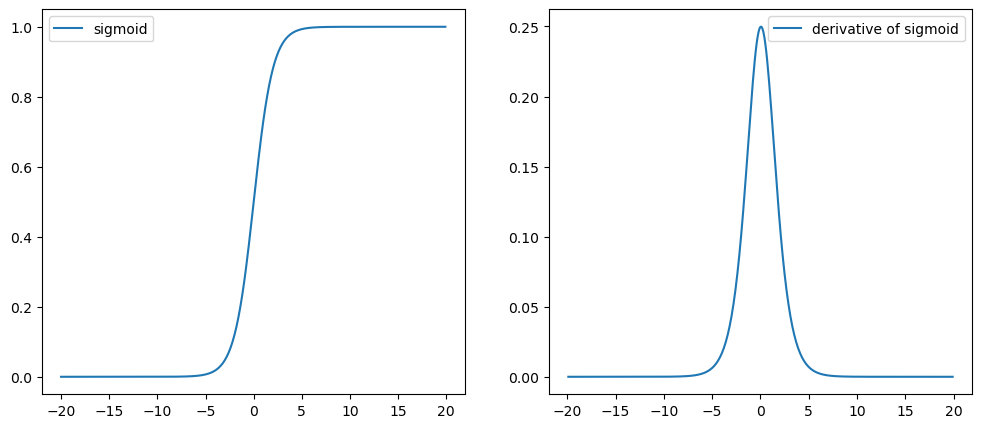
"/>


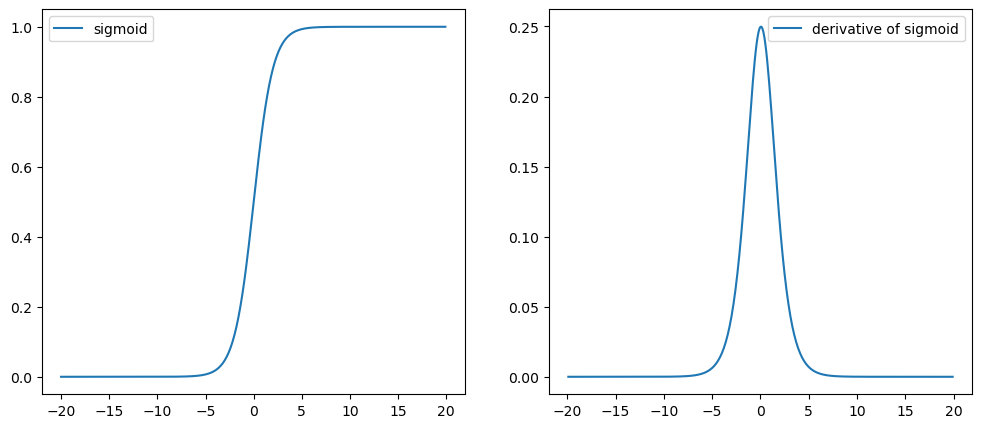

In [2]:
import numpy as np;
import matplotlib.pyplot as plt; step=0.1;
x = np.arange(-20.0, 20.0, step);
fig, axes = plt.subplots(1,2,figsize=(12,5));
y = 1/(1+np.exp(-x));
dy = np.diff(y);
axes[0].plot(x,y)
axes[0].legend(['sigmoid'])
axes[1].plot(x[1:],dy/step);
axes[1].legend(['derivative of sigmoid']);

# Non-linear activation functions:  ReLu - Rectified Linear Unit

Very important: **Activation Functions are computed element-wise.**

$$ \sigma(z)= \max(0,z) \quad \text{ReLu}$$
<br> <center>ReLu is piece-wise linear function</center>
<img src="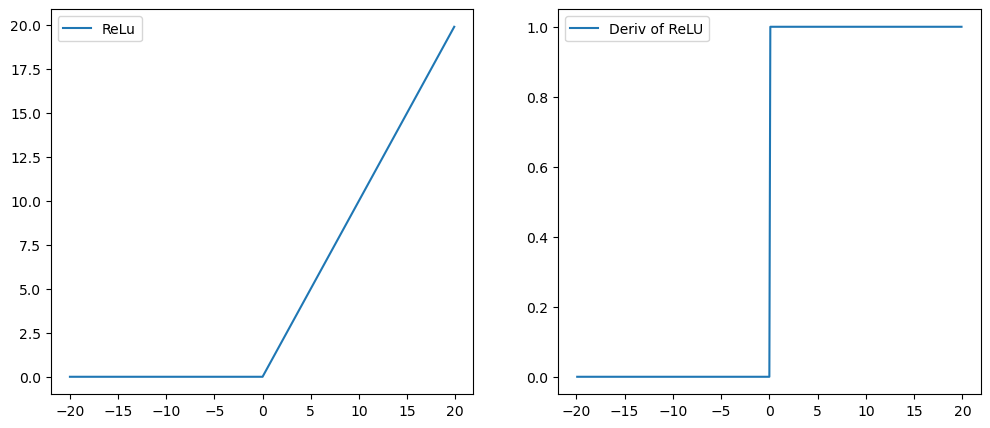
"/>

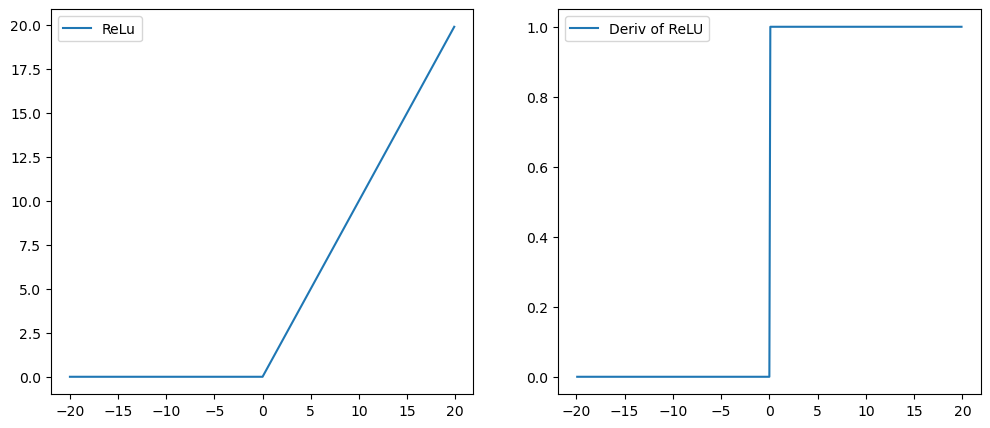

In [3]:
import numpy as np;
import matplotlib.pyplot as plt; step=0.1;
x = np.arange(-20.0, 20.0, step);
fig, axes = plt.subplots(1,2,figsize=(12,5));
y = np.maximum(0,x);
dy = np.diff(y);
axes[0].plot(x,y)
axes[1].plot(x[1:],dy/step);
axes[0].legend(['ReLu'])
_=axes[1].legend(['Deriv of ReLU']);

# Sigmoid

- Used to model output probability
- Nowdays not used in middle layers
- Have to compute $\exp()$
- **Vanishing gradients** for large input magnitude

# ReLU

- Computationally efficient (no exp!)
- No vanishing gradients but do not let pass gradients for negative values
- Converge much faster than sigmoid (6x)
- Not differentiable in zero (subgradients)

# There are other activation functions we do not cover
###  TanH, Leaky ReLU, parametrized ReLU, ELU

# Backpropagation and Differential Programming

# NN can be huge composition of functions! 😱
<br>
<center><img src=https://www.researchgate.net/profile/Tiago-Carvalho-8/publication/330478807/figure/fig1/AS:756995804110849@1557493272678/VGG16-VGG19-Inception-V3-Xception-and-ResNet-50-architectures_W640.jpg width='35%'/></center>



# Three ways of computing the gradients $\nabla_{\mbf{w}}\mathcal{L}(x,y;\mbf{w})$

1. **Manually** (if we change the network, we have to adjust it for a 100 layer neural net) maybe not a good idea, does not scale, even if we use symbolic derivation tools such as Mathematica ✍🏼
2. **Finite Difference** good to check the gradients once you have an automatic way of computing it; **very slow, unfeasible in training!** 👩🏾‍💻
3. **Backpropagation**: application of chain rule of calculus to tensors with a computational graph with caching **(differential programming with automatic differentiation)** 💻

# Backpropagation

# Let's be clear on what we need to compute

$\forall l \in [1\ldots,L]$:
1. $\nabla_{\mbf{W}^l}\mathcal{L}(\mbf{x},y;\{\mbf{W},b\})$
1. $\nabla_{\mbf{b}^l}\mathcal{L}(\mbf{x},y;\{\mbf{W},b\})$
<br><br>
<center><img src='figs/neuron_6.png' width='90%'/></center>

# Once you have gradients on ALL weights $\implies$ We can update

$\forall l \in [1\ldots,L]$:
1. $\mbf{W}^l \leftarrow \mbf{W}^l - \gamma \nabla_{\mbf{W}^l}\mathcal{L}(\mbf{x},y;\{\mbf{W},b\})$
1. $\mbf{b}^l \leftarrow \mbf{b}^l - \gamma \nabla_{\mbf{b}^l}\mathcal{L}(\mbf{x},y;\{\mbf{W},b\})$
<br><br>


<center><img src='figs/neuron_7.png' width='90%'/></center>

# How do we get all the weight updates?

[Mostly taken from here](https://www.youtube.com/watch?v=i94OvYb6noo)

# Chain Rule

Returning to functions of a single variable,
suppose that $y = f(g(x))$
and that the underlying functions 
$y=f(u)$ and $u=g(x)$ 
are both differentiable.
The chain rule states that 


$$\frac{dy}{dx} = \frac{dy}{du} \frac{du}{dx}.$$


What is the **derivative of loss wrt to x in the equation below**? $$y = loss\big(g(h(i(x)))\big)$$

$$\frac{\partial loss}{\partial x} = \frac{\partial loss}{\partial g} \frac{\partial g}{\partial h}\frac{\partial h}{\partial i}\frac{\partial i}{\partial x}$$

# Chain Rule on Directed Acyclic Graph (DAG)

### Automate the computation of derivatives with computer science



$$\mathcal{L}(x,y,z) = (x+y)z$$

$$x=-2;~y=5;~z=-4;$$

The high school way

$$\frac{\partial\mathcal{L}(x,y,z)}{\partial x} =  ?$$

$$\mathcal{L}(x,y,z) = (x+y)z$$

$$x=-2;~y=5;~z=-4;$$

The high school way (as we did until now):

$$\frac{\partial\mathcal{L}(x,y,z)}{\partial x} =  (\mbf{x}z+yz)^{\prime}=(\mbf{x}z)^{\prime}+(yz)^{\prime} = z$$
$$\frac{\partial\mathcal{L}(x,y,z)}{\partial y} =  (xz+\mbf{y}z)^{\prime}=(xz)^{\prime}+(\mbf{y}z)^{\prime} = z$$
$$\frac{\partial\mathcal{L}(x,y,z)}{\partial z} =  x+y $$

# Now with Chain Rule
$$\mathcal{L}(x,y,z) = (x+y)z$$

$$x=-2;~y=5;~z=-4;$$

but we can re-write it with the chain rule:

$$\frac{\partial\mathcal{L}(x,y,z)}{\partial x} =  \big(\underbrace{(\mbf{x}+y)}_{q}z\big)^{\prime}=\frac{\partial\mathcal{L}}{\partial q}\frac{\partial q}{\partial x}$$

# Now with Chain Rule
$$\mathcal{L}(x,y,z) = (x+y)z$$

$$x=-2;~y=5;~z=-4;$$

but we can re-write it with the chain rule:

$$\frac{\partial\mathcal{L}(x,y,z)}{\partial x} =  \big(\underbrace{(\mbf{x}+y)}_{q}z\big)^{\prime}=\frac{\partial\mathcal{L}}{\partial q}\frac{\partial q}{\partial x} = z\frac{\partial q}{\partial x} $$

# Now with Chain Rule
$$\mathcal{L}(x,y,z) = (x+y)z$$

$$x=-2;~y=5;~z=-4;$$

but we can re-write it with the chain rule:

$$\frac{\partial\mathcal{L}(x,y,z)}{\partial x} =  \big(\underbrace{(\mbf{x}+y)}_{q}z\big)^{\prime}=\frac{\partial\mathcal{L}}{\partial q}\frac{\partial q}{\partial x} = z\cdot 1= z $$

# Chain Rule on Directed Acyclic Graph (DAG)

$$\mathcal{L}(x,y,z) = (x+y)z$$

$$x=-2;~y=5;~z=-4;$$

**The computer science way:**

<div align='center'><img src="figs/dag_00.png" width='35%' ></div>

$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

# Chain Rule on Directed Acyclic Graph (DAG)
Even if the problem is very small, we break it down to subproblem so that we can **automate** it:
<div align='center'><img src="figs/dag_00.png" width='35%' ></div>


$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$
 Who is input of $\mathcal{L}$?

$q$ and $z$ are input of $\mathcal{L}$.
$$\frac{\partial\mathcal{L}}{\partial q}, \frac{\partial\mathcal{L}}{\partial z}$$

# Chain Rule on Directed Acyclic Graph (DAG)
Even if the problem is very small, we break it down to subproblem so that we can **automate** it:
<div align='center'><img src="figs/dag_00.png" width='35%' ></div>

$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

What is the derivate? (Just check the operation at the gate)
$$\frac{\partial\mathcal{L}}{\partial q}, \frac{\partial\mathcal{L}}{\partial z}$$

# Chain Rule on Directed Acyclic Graph (DAG)
Even if the problem is very small, we break it down to subproblem so that we can **automate** it:
<div align='center'><img src="figs/dag_00.png" width='35%' ></div>>


$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

What is the derivate? (Just check the operation at the gate)?
$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q$$

# Chain Rule on Directed Acyclic Graph (DAG)
Even if the problem is very small, we break it down to subproblem so that we can **automate** it:
<div align='center'><img src="figs/dag_00.png" width='35%' ></div>


$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

What is the derivate? (Just check the operation at the gate)?
$$\frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Chain Rule on Directed Acyclic Graph (DAG)
Even if the problem is very small, we break it down to subproblem so that we can **automate** it:
<div align='center'><img src="figs/dag_00.png" width='35%' ></div>


$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

OK now we have all the **analytical "local" partial derivatives, we can compute something**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Forward Pass

<div align='center'><img src="figs/dag_01.png" width='37%' ></div>


$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

OK now we have all the **analytical partial derivatives, we can compute something**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Forward Pass

<div align='center'><img src="figs/dag_02.png" width='37%' ></div>


$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

OK now we have all the **analytical partial derivatives, we can compute something**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Forward Pass

<div align='center'><img src="figs/dag_03.png" width='37%' ></div>

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_03.png" width='37%' ></div>

**Act as a base case for the recursion:** $$\frac{\partial\mathcal{L}}{\partial \mathcal{L}}=?$$

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_04.png" width='37%' ></div>

**Act as a base case for the recursion:** $$\frac{\partial\mathcal{L}}{\partial \mathcal{L}}=1$$

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_04.png" width='37%' ></div>

**What is the value of the gradient of $\mathcal{L}$ on $z$?**: 


**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_05.png" width='37%' ></div>

**What is the value of the gradient of $\mathcal{L}$ on $z$?**: 

$$\frac{\partial\mathcal{L}}{\partial z}= q = 3$$

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_05.png" width='37%' ></div>

**What is the value of the gradient of $\mathcal{L}$ on $q$?**: 


**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_06.png" width='37%' ></div>

**What is the value of the gradient of $\mathcal{L}$ on $q$?**: 

$$\frac{\partial\mathcal{L}}{\partial q}= z = -4$$

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_06.png" width='37%' ></div>

**What is the value of the gradient of $\mathcal{L}$ on $y$?**: 


**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass

<div align='center'><img src="figs/dag_06.png" width='37%' ></div>

**What is the value of the gradient of $\mathcal{L}$ on $y$?**: 
$$\frac{\partial\mathcal{L}}{\partial y} = \frac{\partial\mathcal{L}}{\partial q}\frac{\partial q}{\partial y} = z\cdot 1= -4$$

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Backward Pass
<div align='center'><img src="figs/dag_07.png" width='37%' ></div>

**This is what we wanted:**
$$\frac{\partial\mathcal{L}}{\partial x},\frac{\partial\mathcal{L}}{\partial y},\frac{\partial\mathcal{L}}{\partial z}$$

**This is what we have**

$$\frac{\partial\mathcal{L}}{\partial q}=z, \frac{\partial\mathcal{L}}{\partial z}=q, \frac{\partial\mathcal{q}}{\partial x}=1, \frac{\partial\mathcal{q}}{\partial y}=1$$

# Check with our manual derivation ✅

<div align='center'><img src="figs/dag_08.png" width='37%' ></div>

The high school way (as we did until now):

$$\frac{\partial\mathcal{L}(x,y,z)}{\partial x} =  (\mbf{x}z+yz)^{\prime}=(\mbf{x}z)^{\prime}+(yz)^{\prime} = z = -4$$
$$\frac{\partial\mathcal{L}(x,y,z)}{\partial y} =  (xz+\mbf{y}z)^{\prime}=(xz)^{\prime}+(\mbf{y}z)^{\prime} = z = -4$$
$$\frac{\partial\mathcal{L}(x,y,z)}{\partial z} =  x+y = +3 $$

# You know what? I do not trust math, I want to verify with a machine ✅

# Pytorch check
```python
from torch import tensor

def neural_net(x,y,z):
    return (x+y)*z

x, y, z = tensor(-2., requires_grad=True), tensor(5.,requires_grad=True), tensor(-4., requires_grad=True)
loss = neural_net(x,y,z) # forward pass
loss.backward()          # backward (after this I can check the gradients)
for el in [x,y,z]:
    print(el.grad)
```
```
tensor(-4.)
tensor(-4.)
tensor(3.)
```

In [22]:
from torch import tensor

def neural_net(x,y,z):
    loss = (x+y)*z
    return loss

x, y, z = tensor(-2., requires_grad=True), tensor(5.,requires_grad=True), tensor(-4., requires_grad=True)
loss = neural_net(x,y,z) # forward pass

loss.backward() #backward (ok now I can check the gradients)
for el in [x,y,z]:
    print(el.grad)

tensor(-4.)
tensor(-4.)
tensor(3.)


In [20]:
from torch import tensor

def neural_net(x,y,z):
    loss = (x+y)*z
    return loss

x, y, z = tensor(-2.)tensor(5.,requires_grad=True), tensor(-4., requires_grad=True)
loss = neural_net(x,y,z)

loss.backward()
for el in [x,y,z]:
    print(el.grad)

tensor(-4.)
tensor(-4.)
tensor(3.)


# General Recipe for Chain Rule over DAGs [Forward]

**Just remember what you have to do at a generic gate:**


<div align='center'><img src="figs/local_grad.png" width='52%' ></div>

# General Recipe for Chain Rule over DAGs  [Backward]

**Multiply the gradient that you receive with your local gradient**


<div align='center'><img src="figs/local_grad_01.png" width='52%' ></div>

# Logistic Regression Computational Graph could be simplified

$$
f(w, x)=\frac{1}{1+e^{-\left(w_{0} x_{0}+w_{1} x_{1}+b\right)}}
$$

This is what implement the **Sigmoid Layer in Pytorch:**

<div align='center'><img src="figs/dag_logistic_reg.png" width='57%' ></div>


# Are we done with training neural nets?

# Not completely: till now scalars, but we have matrices and vectors!

# Now this looks more familiar

$\forall l \in [1\ldots,L]$:
1. $\mbf{W}^l \leftarrow \mbf{W}^l - \gamma \nabla_{\mbf{W}^l}\mathcal{L}(\mbf{x},y;\{\mbf{W},b\})$
1. $\mbf{b}^l \leftarrow \mbf{b}^l - \gamma \nabla_{\mbf{b}^l}\mathcal{L}(\mbf{x},y;\{\mbf{W},b\})$
<br><br>
<div align='center'><img src="figs/graph_01.png" width='80%' ></div>

$$\chain{\mathcal{L}}{\mbf{W}^1} = \chain{\loss}{\mbf{z}}\chain{\mbf{z}}{\mbf{W}^1}$$

$$\chain{\mathcal{L}}{\mbf{W}^1} = \chain{\loss}{\mbf{z}}\underbrace{\chain{\mbf{z}}{\sigma}\chain{\mbf{\sigma}}{\mbf{W}^1}}_{\chain{\mbf{z}}{\mbf{W}^1}}$$

$$\chain{\mathcal{L}}{\mbf{W}^1} = \chain{\loss}{\mbf{z}}\chain{\mbf{z}}{\sigma}\underbrace{\chain{\mbf{\sigma}}{\mbf{h}}\chain{\mbf{h}}{\mbf{W}^1}}_{\chain{\mbf{\sigma}}{\mbf{W}^1}}$$